In [1]:
# general import
import os
import pickle
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import copy

# torch
import torch
import torch.nn as nn
import torch.optim as optim

# my own
from tasks import get_data
from myutils import *
from topology import gen_lattice, compute_dist

# increase cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

dtype = torch.float
device = torch.device("cpu")

# SOME USEFUL DEFINITIONS
relu = lambda x : (x > 0) * x
def pr(h, b):
    bh = b*h
    if bh.any() > 20:
        return 1. * (h > 0)
    else:
        return np.exp(b * h) / (2 * np.cosh(b * h))

## Set task

### Available task:

Random Tasks:
- __RANDOM__ : random iid gaussian inputs mapped to random binary outputs
- __RANDOM-Y__ : random iid gaussian inputs mapped to random gaussian outputs
- __NLGP__ : spatially correlated inputs with output labels defined by their correlation length
- __RANDOM-FF-Teacher__: random Feed Forward teacher networkm with two layers with binary output
- __RANDOM-FF-Teacher-Y__: random Feed Forward teacher network with two layers with continuous output
- __RANDOM-RNN-Teacher__ : random Recurrent teacher network with binary output
- __RANDOM-RNN-Teacher-X__ : random Recurrent teacher network targets defined as steady state activities
- __RANDOM-RNN-Teacher-Y__ : random Recurrent teacher network with continuous output


Datasets:
- __MNIST1D__
- __MNIST__
- __MNIST10__
- __FashionMNIST__
- __CIFAR10__
- __CIFAR100__

In [264]:
# SET MAIN PARAMS

pars = Pars()

## random task name
#pars.dataset = "RANDOM"
# pars.dataset = "RANDOM-Y"
pars.dataset = "NLGP"
# pars.dataset = "RANDOM-FF-Teacher"
# pars.dataset = "RANDOM-FF-Teacher-Y"
# pars.dataset = "RANDOM-RNN-Teacher"
# pars.dataset = "RANDOM-RNN-Teacher-X"
# pars.dataset = "RANDOM-RNN-Teacher-Y"

## dataset name
# pars.dataset = "MNIST1D"
# pars.dataset = "MNIST"
# pars.dataset = "MNIST10"
# pars.dataset = "FashionMNIST"
# pars.dataset = "CIFAR10"
# pars.dataset = "CIFAR100"

## random dataset specific options
pars.exp_input = False # exponentially distributed input (default is gaussian)
pars.rho = 0.4 # input covariance for RANDOM dataset

## teacher-student FF options
pars_teacher = {}
# pars_teacher["K"] = 1 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "linear" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = True # constant output weights
# pars_teacher["num_out"] = 1 # number of output units 
# pars_teacher["g"] = 1. # gain of ff weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

# ## teacher-student RNN options
# pars_teacher = {}
# pars_teacher["K"] = 40 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "relu" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["discrete_time"] = False # type of temporal dynamics
# pars_teacher["dt"] = 0.1 # time discretization
# pars_teacher["eye_in"] = True # identity input weights
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = False # constant output weights
# pars_teacher["num_out"] = 1 # number of output units 
# pars_teacher["g"] = 0.8 # gain of recurrent weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

## NLGP specific options
pars.torus = False # whether to use a torus topology
pars.g_nonlin = 1e-10 # gain parameter for nonlinearity
pars.xis = [2.4] # lenght-scales of mixtures

## spatial options
pars.dim = 1 # input dimension
pars.lN =100 # linear input size
pars.normalize = False # normalize inputs (some dataset are already normalized)

## misc options
pars.seed_data = 10
pars.data_dir = f'data'
pars.save_dir = f'results_notebook'

# # TO DIRECTLY DOWNLOAD MNIST1D USE THE FOLLOWING:
# import requests
# url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
# r = requests.get(url, allow_redirects=True)
# save_dir_dataset = save_dir + "/" + dataset
# open(f'{data_dir}/mnist1d_data.pkl', 'wb').write(r.content)

# General options
pars.alpha_train = 0.1 # fraction of training patterns wrt N in a random task
pars.alpha_test = 2/pars.lN # fraction of test patterns wrt N in a random task
pars.span_h = False # generate all h in range (only makes sense for N=2 or N=3)

In [265]:
# GET DATASET
def get_new_dataset(pars):
    makedir(pars.data_dir)
    data_and_properties = get_data(pars, dtype=dtype, device=device)
    train_dataset, test_dataset, teacher_weights, x_teacher = data_and_properties
    print(f"{pars.dim} dimensional inputs of size {pars.lN}^{pars.dim} = {pars.N}")
    print(f"num train: {pars.num_train}, num test: {pars.num_test}, num label: {pars.num_label}")

    # gen patterns
    # X = 1. * (np.random.rand(P,N) <= sparsities[None])
    X = 0.5 * (1 + np.sign(train_dataset.tensors[0].numpy()))   # 0 or 1
    Y = 2. * X - 1.                                             # -1 or 1
    
    return train_dataset, test_dataset, teacher_weights, x_teacher, X, Y

train_dataset, test_dataset, teacher_weights, x_teacher, X, Y = get_new_dataset(pars)

1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


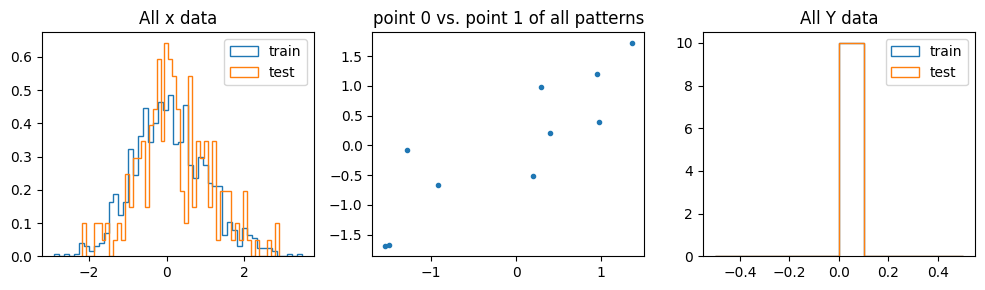

In [266]:
# WATCH RANDOM DATA DISTRIBUTION

if "RANDOM" in pars.dataset or "GP" in pars.dataset:
    plt.figure(figsize=(10,3))

    X_to_plot_train, y_to_plot_train = extract_tensors(train_dataset)
    if pars.num_test is not None:
        X_to_plot_test, y_to_plot_test = extract_tensors(test_dataset)
    
    # Plot distribution of all obtained datapoints (both train and test)
    plt.subplot(131)
    plt.hist(X_to_plot_train.flatten().tolist(), bins=50, density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(X_to_plot_test.flatten().tolist(), bins=50, density=True, histtype="step", label="test");
    plt.title("All x data")
    plt.legend();

    # First data-point vs 2nd data-point, to see correlation between them (only training dataset)
    plt.subplot(132)
    plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,1], '.');
#     plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,2], '.');
    plt.title("point 0 vs. point 1 of all patterns")

    # Distribution of all values obtained for y (both train and test)
    plt.subplot(133)
    plt.hist(y_to_plot_train.flatten().tolist(), density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(y_to_plot_test.flatten().tolist(), density=True, histtype="step", label="test");
    plt.legend();
    plt.title("All Y data")

    plt.tight_layout()

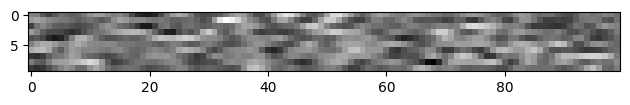

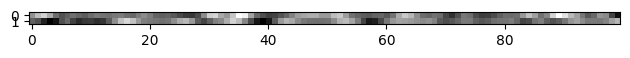

In [267]:
# WATCH DATASET
watch_dataset(train_dataset, test_dataset, pars)

## Run learning

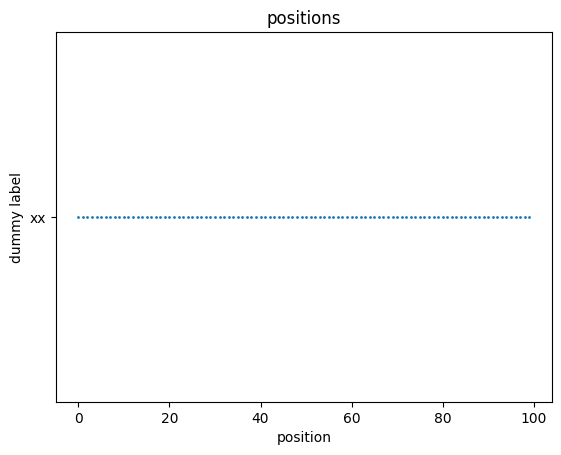

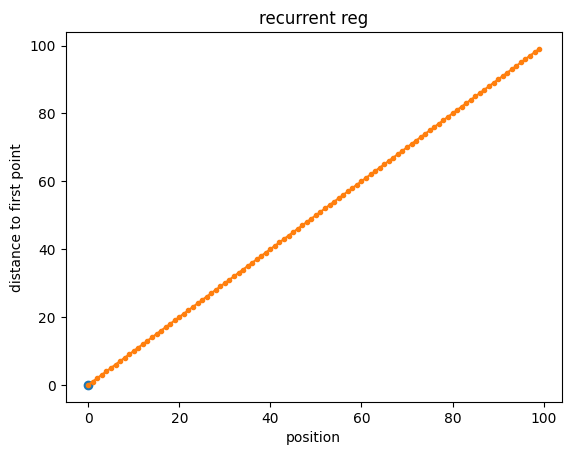

In [268]:
# network options
lN, N = pars.lN, pars.N            # Size of the patterns to be learned (lN for linear dimension, N for total dimension)
P = pars.num_train                 # Number of patterns to learn
fe = -1                            # Fraction of excitatory connections
sparsity_mean = 0.                 # If you use sparsity instead of sign(train_dataset), you'll generate a sequence 
#                                  # which will be later give the probability to have a 0 in X
sparsity_std = 0.                  # To control std for sparsity
noself = True                      # Set diagonal to 0, to prevent trivial solution J=id(NxN)
use_bias = False                    # Use a bias (I, input current): H = JX + I
learn_bias = True                  # Learn bias or not (fix it instead)
bias = 0.                          # Initialize the bias 
norm_dependent_stability = False   # Stability is proportional to ||J^2|| (otherwise it's proportional to sqrt(N))
embed_model = True                 # Embed the model to a graph
random_pos = False                  # Embeded positions are random
dim = pars.dim                     # Dimension of the data (it's already previously defined)
torus = pars.torus                 # Whether to use a torus topology (alreade defined previously)

# learning options
num_epochs = 200          # Number of epochs
print_every = 10          # Verbose option
lr = 0.2                  # Learning rate
delta0 = 0.2              # Stability regularization
gam = 0.                  # Regularization strength (L1?)
gam_en = 0.               # Energy regularization
gam_sign = 0.15            # Sign regularization
gam_pos = 0#1e-6             # Position regularization
relu2 = True             # Whether to use relu or relu^2 as activation function 
maxweight = 5           # Don't let weight be too large
square_dist = False       # Whether to set distance as (xi^2+xj^2) or as np.abs(xi^2+xj^2)
stop_at_zero_err = False  # You may want to continue training after 0 error because sign regularization can still improve
signreg_tol = 1e-10

# ## homogeneous sparsities
# sparsities = sparsity_mean + np.random.randn(N) * sparsity_std
# sparsities = np.clip(sparsities, a_min=0, a_max=1)
# ## space-dependent sparsities
# sparsities = np.linspace(0.9, 0.1, N)
# sparsities = np.ones(N) * 0.95
# sparsities[:N//2] = 0.15

# if sparsity_std > 0: # Plot sparsities vs X
#     plt.plot(sparsities, '.:')
#     plt.plot(X.mean(0), '.-')
#     plt.title('sparsities');
    
## init J0 and I0
Ne = int(fe * N)                             # Initial fraction of excitatory connections
I0 = bias * np.ones(N)                        # Initial bias (convert to vector, same initial values for each entry)
if fe == -1:                               # If  not ordered excitatory/inhibitory connections
    J0 = np.random.randn(N, N) / np.sqrt(N)   # Initialize J randomly ~ Gaussian(0,1)
else:                                      # If ordered E/I connections
    J0 = np.random.rand(N, N) / np.sqrt(N)    # Initialize J randomly ~ Uniform(0,1)
    J0[:,Ne:] *= -1.                          # And force a fraction of the entries to be negative
diag_indices = np.diag_indices(N)          # To set J(diagonal) = 0 if noself
if noself:
    J0[diag_indices] = 0.

## generate positions    
if embed_model:                              # Embed ANN to a space (1-D or 2-D, 3-D is not yet implemented)
    if dim == 1:                         # For 1-D
        L = N                                # Linear dimension
        totpoints = [L]                      # Initialize position vector
    elif dim == 2:                       # For 2-D
        L = int(np.sqrt(N))                  # Linear dimension (should be sqrt(N))
        if L**2 != N:                        # If L^2 !=N, throw an error
            print("WARNING: need a perfect square in dimension 2")
        totpoints = [L, L]                   # Initialize position matrix
    else:                                # dimension >= 3 is not implemented yet
        raise ValueError("dim = 3 not implemented yet!")

    pos = gen_lattice(dim=dim, lens=[L,L], torus=torus, random_pos=random_pos, tot_points=totpoints, centered=False)  # Generate position matrix
    dist = compute_dist(dim, pos, pos, lens=[L,L], torus=torus, square=square_dist)                              # Generate distances matrix
    # dist = np.tanh(dist/10) * 10             # Can force distance matrix to have a certain distribution, such as a tanh
    pos = pos.numpy()                          # Convert position matrix to numpy array
    dist = dist.numpy()                        # Convert distance matrix to a numpy array

    # visualize positions
    if dim == 1:                                             # Plot position matrices (only if embeded to 1-D)
        plotmax=N                                            # Max number of points to plot, to avoid overloading the image
        plt.plot(pos[0:plotmax], 0 * np.ones_like(pos[0:plotmax]), 'o', ms=1)      # Do the plot
        plt.title('positions')                               # Title
        plt.yticks([0],['xx'])                               # Hide y axis
        plt.xlabel('position')
        plt.ylabel('dummy label')
        plt.show()                                           # Show


        # recurrent reg
        i_plot = [0]#[L//2]                # Take one neuron (the one in the middle or the first one, they may have a random position anyway)
        for i in i_plot:                   # Plot distances from that neuron to the others
            plt.plot(pos[i], 0, 'o', label='first point')
            plt.plot(pos[0:plotmax], dist[i_plot[0],0:plotmax], '.-')
        plt.xlabel('position')
        plt.ylabel('distance to first point')
        plt.title('recurrent reg')
        plt.show()

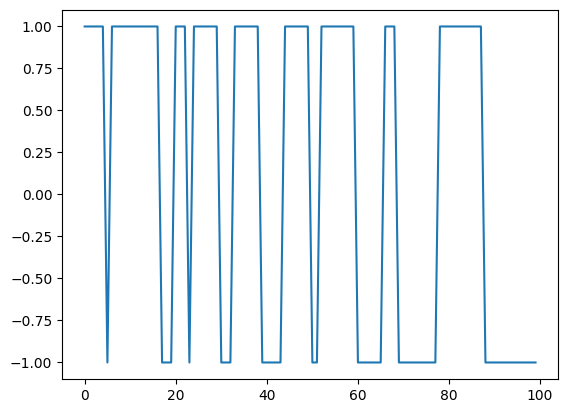

In [269]:
plt.plot(Y[6,:])

In [248]:
def train_network(X, Y, N, P, J0, I0):
    # init containers
    J = J0.copy()
    I = I0.copy()
    errs, en_regs, sign_regs, pos_regs = [], [], [], []
    
    # run optimization    
    ok = False            # Tells when to stop
    for ep in range(num_epochs):
        
        # run through data
        perm = np.random.permutation(P)  # random permutation 
        for mu in perm:                  # Go neuron by neuron in random order
            
            # compute fields
            H = J @ X[mu]                # H = J X_mu; row i is H^{i} = J_{i1} X_{mu,1} + J_{i2} X_{mu,2} + ... + J_{iN} X_{mu,N}
            if use_bias:                 # Add bias
                H += I                   # H = J X_mi + I
                
            # learning step
            delta = delta0 * np.sqrt((J**2).sum(-1)) if norm_dependent_stability else delta0 * np.sqrt(N)
            err = Y[mu] * ((Y[mu] * H) <= delta) #Should be <= ?
            derr = np.outer(err, X[mu])
            J += lr * derr
            J -= lr * gam * J
            
            # train input bias
            if use_bias and learn_bias:
                I += lr * err
            
            # apply energy regularization
            if gam_en:
                en_reg = 0.5 * (J**2 @ X[mu]).mean()
                J -= lr * gam_en * J * X[mu][None]
    
            # apply sign regularization
            if gam_sign:
                if relu2:
                    reluscorr = relu(-np.einsum('ki,li->kli', J, J))
                    sign_reg = 0.25 * (reluscorr**2).sum() / N**2
                    dsign_reg = -np.einsum('kli,li->ki' ,reluscorr, J)
                else:
                    scorr = -np.einsum('ki,li->kli', J, J)
                    thetascorr = 1. * (scorr >= 0)            
                    sign_reg = 0.5 * (thetascorr * scorr).sum() / N**2
                    dsign_reg = -np.einsum('ijk,ji->ik', thetascorr, J)
                J -= lr * gam_sign * dsign_reg
                
            # apply position regularization
            if gam_pos:
                J -= lr * gam_pos * J * dist
                            
            # enforce constraints
            if Ne > -1:
                np.clip(J[:,:Ne], 0., maxweight, out=J[:,:Ne])
                np.clip(J[:,Ne:], -maxweight, 0., out=J[:,Ne:])
                #Need to inforce maxweight for Ne==-1, maybe do else: np.clip(J[:,:], -maxweight, maxweigh, out=J[:,:])
            else:
                np.clip(J, -maxweight, maxweight, out=J)
            if noself:
                J[diag_indices] = 0.
                            
        # compute errors and print
        if ep % print_every == 0:
            
            # compute loss on entire training set
            Hs = X @ J.T
            if use_bias:
                Hs += I[None]
            err = ((Hs * Y) <= delta).mean()
            errs += [err]
            
            # compute en reg
            if gam_en:
                en_reg = 0.5 * (X @ J**2).mean()
                en_regs += [en_reg]
            
            # compute sign reg on J
            if gam_sign:
                reluscorr = relu(-np.einsum('ik,jk->ijk', J, J))
                if relu2:
                    sign_reg = 0.25 * (reluscorr**2).sum() / N**2
                else:
                    sign_reg = 0.5 * reluscorr.sum() / N**2
                sign_regs += [sign_reg]
            
            if gam_pos:
                pos_reg = 0.5 * (J**2 * dist).mean()
                pos_regs += [pos_reg]
            
            # print info
            toprint = f'ep: {ep} loss: {err}'
            if gam_en:
                toprint += f' en reg: {en_reg}'
            if gam_sign:
                toprint += f' sign reg: {sign_reg}'
            if gam_pos:
                toprint += f' pos reg: {pos_reg}'
            print(toprint)
            
            # optionally stop at convergence
            if (err.sum() == 0):
                if not ok:
                    ep_conv = ep
                    ok = True
                if (stop_at_zero_err or sign_reg.sum() < signreg_tol):
                    break
                    
    if not ok:
        print(f'loss not zero in {ep} epochs - min av error {errs[-1]}')
    else:
        print(f'zero loss converged at {ep_conv} epochs')
    
    return J, I, errs, en_regs, sign_regs, pos_regs

In [249]:
# run an example
J, I, errs, en_regs, sign_regs, pos_regs  = train_network(X, Y, N, P, J0, I0)

ep: 0 loss: 0.423 sign reg: 0.01993151019751406
ep: 10 loss: 0.107 sign reg: 0.0028871253633061846
ep: 20 loss: 0.007 sign reg: 0.0001490335930066318
ep: 30 loss: 0.0 sign reg: 1.4689412637645323e-06
ep: 40 loss: 0.0 sign reg: 3.5106932433566366e-07
ep: 50 loss: 0.0 sign reg: 7.980056315959348e-08
ep: 60 loss: 0.0 sign reg: 2.5970871156165698e-08
ep: 70 loss: 0.0 sign reg: 1.3363618960627806e-07
ep: 80 loss: 0.0 sign reg: 6.10223399303447e-08
ep: 90 loss: 0.0 sign reg: 3.0627904400944075e-08
ep: 100 loss: 0.0 sign reg: 1.6104338157885173e-08
ep: 110 loss: 0.0 sign reg: 8.675411133521468e-09
ep: 120 loss: 0.0 sign reg: 4.734581858489367e-09
ep: 130 loss: 0.0 sign reg: 2.602241430291805e-09
ep: 140 loss: 0.0 sign reg: 1.4358255331374457e-09
ep: 150 loss: 0.0 sign reg: 7.939382765174513e-10
ep: 160 loss: 0.0 sign reg: 4.395279087579073e-10
ep: 170 loss: 0.0 sign reg: 2.434843452467457e-10
ep: 180 loss: 0.0 sign reg: 1.3493152442011065e-10
ep: 190 loss: 0.0 sign reg: 7.478995162717669e-11


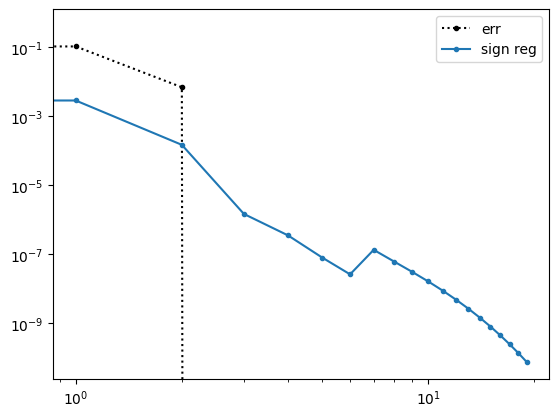

In [250]:
plt.plot(errs, '.:', c='black', label='err');
if gam_en:
    plt.plot(en_regs, '.-', label='en reg');
if gam_sign:
    plt.plot(sign_regs, '.-', label='sign reg');
if gam_pos:
    plt.plot(pos_regs, '.-', label='pos reg');
plt.legend();
    
plt.xscale('log');
plt.yscale('log');

## Check stability of attractors by running network dynamics

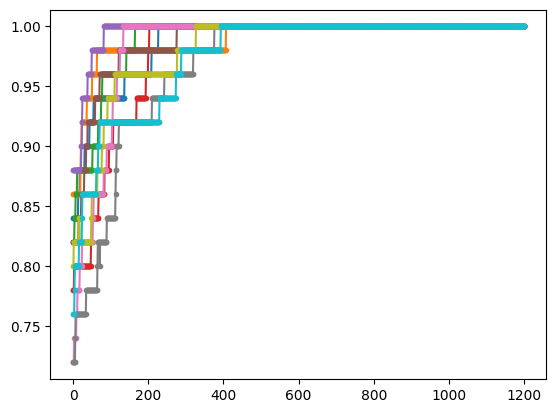

In [251]:
# set pars
mu = 0                  # Select one sample of the training data
num_samples = 10         # How many times we will play with the selected sample
beta = 20               # Beta for a Boltzmann distribution which gives the probability of flipping back
num_iter = 1200         # 
p_flip = 0.1            # Percentage of positions we will flip

# init network
x = np.tile(X[mu], num_samples).reshape(num_samples, N)    # Copy X[mu] P times
flip_init = np.random.rand(num_samples, N) <= p_flip       # Decide the positions you will flip
x[flip_init] = 1 - x[flip_init]                            # Flip the points

# run dynamics
xs = np.zeros((num_iter, num_samples, N))                  # Initialize container for the evolution of x
for it in range(num_iter):                              # Run num_iter times
    xs[it] = x.copy()                                      # Save the value of x at this iteration
    h = x @ J.T + I[None]                                  # x*J+I
    select = np.random.randint(N, size=num_samples)        # Select num_samples points, to track one point per sample
    prob = pr(-(2. * x[range(num_samples), select] - .1) * h[range(num_samples), select], beta) #(e^{-bh})/(e^{bh}+e^{-bh})
    toflip = np.random.rand(num_samples) < prob
    x[toflip, select[toflip]] = 1 - x[toflip, select[toflip]]

# compute and plot overlaps
ov = np.einsum('tmi,i->mt', 2*xs-1, 2*X[mu]-1) / N

plt.plot(ov.T, '.-');

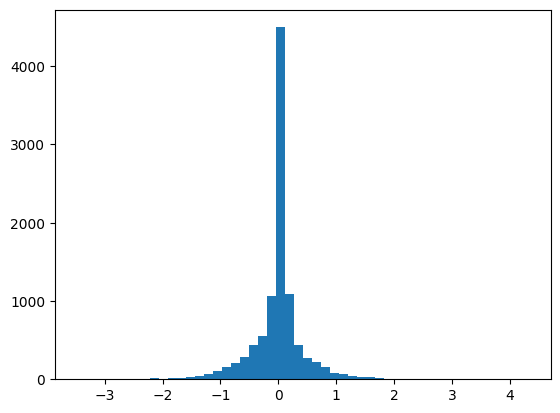

In [252]:
plt.hist(J.flatten(), bins=50);

## Analysis

### Total fields before and after training

In [253]:
I0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Before training:
delta_minus: 1.8314309052666216
delta_plus: -2.345251786913086

After training:
delta_minus: -2.0004380151477568
delta_plus: 2.0129857803083557


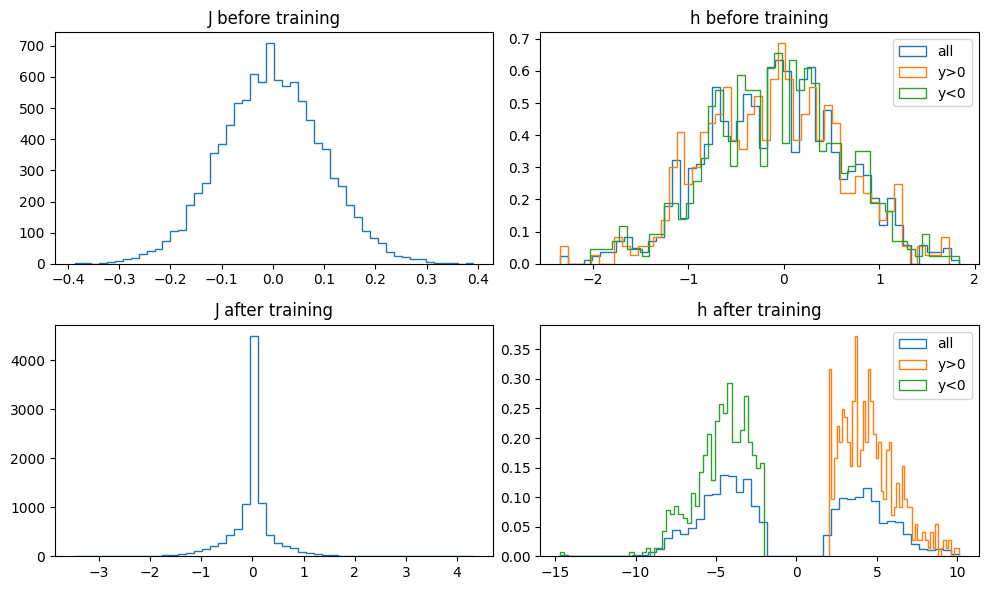

In [254]:
plt.figure(figsize=(10,6))

# before training
Hs0 = X @ J0.T + I0[None]             # Field H, before training
delta_minus0 = np.max(Hs0[Y<0])       # Max H such that X=0 (Y=-1)
delta_plus0 = np.min(Hs0[Y>0])        # Min H such that Y=1 (Y=1)
print("Before training:")             # Print the values
print("delta_minus:", delta_minus0)
print("delta_plus:", delta_plus0)

plt.subplot(221)                                    # Plot histogram with all values of J before training
plt.hist(J0.flatten(), bins=50, histtype="step");
plt.title('J before training')
plt.subplot(222)                                    # Plot histogram of H beore training, including: all values, those st Y<0 and st Y>0
plt.hist(Hs0.flatten(), bins=50, density=True, histtype="step", label='all');
plt.hist(Hs0[Y>0], bins=50, density=True, histtype="step", label='y>0');
plt.hist(Hs0[Y<0], bins=50, density=True, histtype="step", label='y<0');
plt.title('h before training')
plt.legend();

# after training                       
Hs = X @ J.T + I[None]                # Field H, after training
delta_minus = np.max(Hs[Y<0])         # Max H such that X=0 (Y=-1)
delta_plus = np.min(Hs[Y>0])          # Min H such that Y=1 (Y=1)
print("\nAfter training:")            # Print the values
print("delta_minus:", delta_minus)
print("delta_plus:", delta_plus)

plt.subplot(223)                      # Plot histogram with all values of J after training
plt.hist(J.flatten(), bins=50, histtype="step");
plt.title('J after training')
plt.subplot(224)                      # Plot histogram of H after training, including: all values, those st Y<0 and st Y>0
plt.hist(Hs.flatten(), bins=50, density=True, histtype="step", label='all');
plt.hist(Hs[Y>0], bins=50, density=True, histtype="step", label='y>0');
plt.hist(Hs[Y<0], bins=50, density=True, histtype="step", label='y<0');
plt.title('h after training')
plt.legend();

plt.tight_layout();

### Effective signs for the recurrent weights

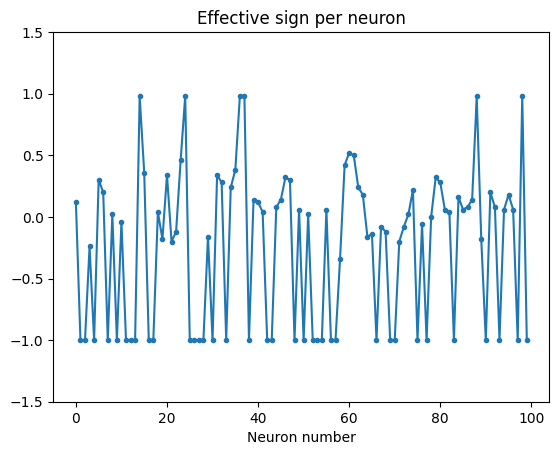

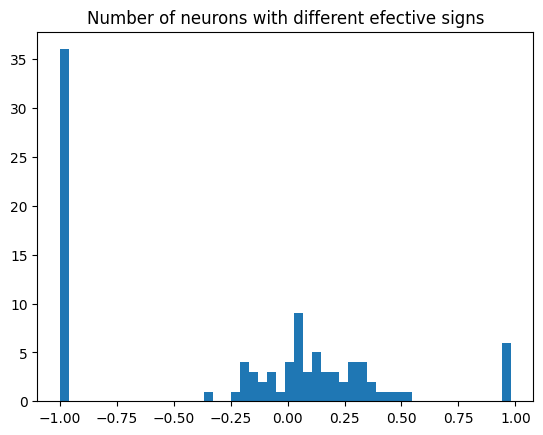

fe_eff: 0.48
J_eff:
[['JEE', 'JEI'], ['JIE', 'JII']]
[[ 0.23566098 -0.25183442]
 [ 0.22404924 -0.25175698]]
I_eff:
[0. 0.]


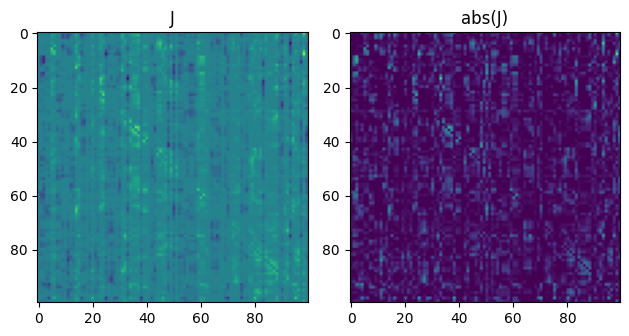

Dim is 1


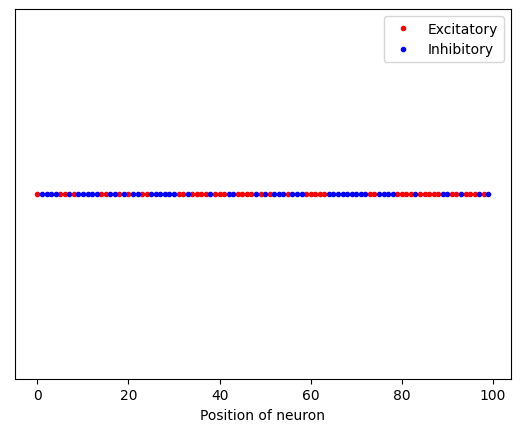

In [255]:
## Poorly defined quantity: must probably find a better one that filters out zero weights
signJ = (2. * (J > 0.) - 1.).mean(0)   # Mean sign of the output of each variable (should be ideally 1 or -1, or 0 if the neuron is silent)
#signJ= (np.sign(J)).mean(0)

if fe > 0:                              # If the sign is predefined, we already know which are positive and negative
    indE = range(Ne)   
    indI = range(Ne,N)
else:                                   # If the sign is not predefined, choose those which are positive and negative
    indE = np.arange(N)[signJ > 1e-6]
    indI = np.arange(N)[signJ <= 1e-6]

plt.plot(signJ, '.-');                  # Plot the effective sign of each neuron, to see the distribution of excitatory and inhibitory neurons
plt.ylim(-1.5,1.5)
plt.title('Effective sign per neuron')
plt.xlabel('Neuron number')
plt.show()

plt.hist(signJ, bins=50);               # See how many neurons are excitatory and how many are inhibitory
plt.title('Number of neurons with different efective signs')
plt.show()

Ne_eff = (signJ>0).sum()                # Number of excitatory neurons
Ni_eff = N - Ne_eff                     # Number of inhibitory neurons
fe_eff = Ne_eff / N                     # Fraction of excitatory neurons
print('fe_eff:', fe_eff)                # Print the fraction of excitatory neurons

# Remember J[to][from] of J[to,from] is the same
JEE = J[indE][:,indE]                   # Excitatory neurons which project to excitatory neurons
JEI = J[indE][:,indI]                   # Inhibitory neurons which project to excitatory neurons
JIE = J[indI][:,indE]                   # Excitatory neurons which project to inhibitory neurons
JII = J[indI][:,indI]                   # Inhibitory neurons which project to inhibitory neurons

J_eff = np.array([[JEE.mean(), JEI.mean()], # Print mean of each of the J[to][from] 
                 [JIE.mean(), JII.mean()]])
print("J_eff:")
print([['JEE','JEI'],['JIE','JII']])
print(J_eff)

I_eff = np.array([I[indE].mean(), I[indI].mean()]) # Now the same for I I[for], excitatory and inhibitory
print("I_eff:")
print(I_eff)

if embed_model:                             #
    plt.subplot(121)                        # Plot J colormap, columns represent from, rows represent to
    plt.imshow(J, origin='upper');          #
    plt.title('J')                          
    plt.subplot(122)                        # Same but with absolute values
    plt.imshow(np.abs(J), origin='upper');
    plt.title('abs(J)')
    plt.tight_layout();
    plt.show()

    if dim == 1:           # Plot position of neurons, mark them as red or blue depending on whether the neuron is excitatory or inhibitory
        print('Dim is 1')  
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=3, c='red',label='Excitatory')    # Excitatory
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=3, c='blue',label='Inhibitory')   # Inhibitory
        plt.xlabel('Position of neuron')
        plt.yticks([])
        plt.legend(loc='upper right')
        plt.show()
    else:
        plt.imshow(np.sign(signJ).reshape(lN,lN))

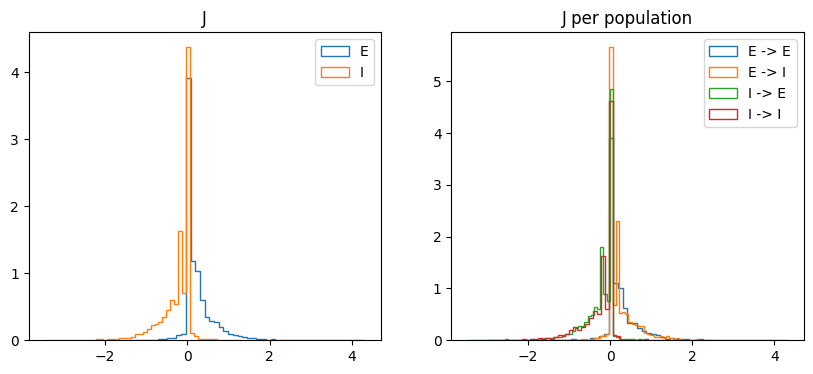

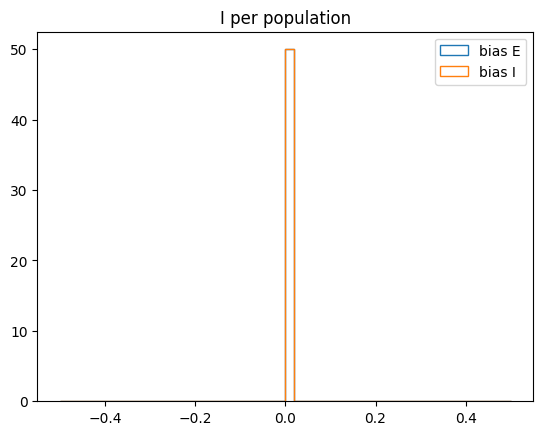

In [257]:
# weights per population

if fe == -1 and not gam_sign:
    plt.hist(J.flatten(), bins=50, density=True, histtype="step", label='J');
#     plt.hist(I, bins=50, density=True, histtype="step", label='bias');
    plt.legend();
else:
    plt.figure(figsize=(10,4))
    
    plt.subplot(121)       # Histogram of J values, split in excitatory and inhibitory neurons
    plt.hist(J[:,indE].flatten(), bins=50, density=True, histtype="step", label='E');  # Excitatory neurons
    plt.hist(J[:,indI].flatten(), bins=50, density=True, histtype="step", label='I');  # Inhibitory neurons
    plt.title('J')
    plt.legend()

    plt.subplot(122)      # Histogram of J values, categorized in From -> To (neurons)
    plt.hist(JEE.flatten(), density=True, bins=50, histtype="step", label="E -> E");  # From E to E
    plt.hist(JIE.flatten(), density=True, bins=50, histtype="step", label="E -> I");  # From E to I
    plt.hist(JEI.flatten(), density=True, bins=50, histtype="step", label="I -> E");  # From I to E
    plt.hist(JII.flatten(), density=True, bins=50, histtype="step", label="I -> I");  # From I to I
    plt.title('J per population')
    plt.legend();

    # plt.subplot(122)
    # plt.hist(J[indE][:,indE].flatten(), density=True, bins=50, histtype="step", label="E -> E");
    # plt.hist(J[indI][:,indE].flatten(), density=True, bins=50, histtype="step", label="E -> I");
    # plt.hist(J[indE][:,indI].flatten(), density=True, bins=50, histtype="step", label="I -> E");
    # plt.hist(J[indI][:,indI].flatten(), density=True, bins=50, histtype="step", label="I -> I");
    # plt.title('J per population')
    # plt.legend();
    
    plt.show()           # Histogram of biases, split in bias for E or for I neurons
    plt.hist(I[indE], bins=50, density=True, histtype="step", label='bias E');   # bias for excitatory neurons
    plt.hist(I[indI], bins=50, density=True, histtype="step", label='bias I');   # bias for inhibitory neurons
    plt.title('I per population')
    plt.legend();

In [369]:
np.argmax(JmeanfromE)

49

### Look at receptive and projective fields

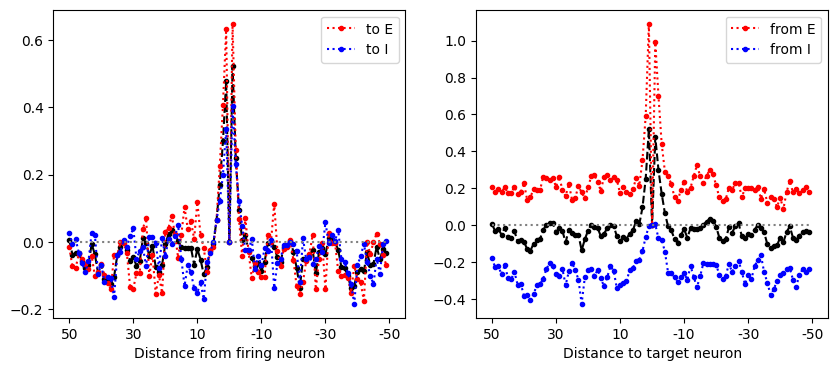

In [360]:
# Initialize holders
Jmeanto = np.zeros(N)
Jmeanfrom = np.zeros(N)
JmeantoE = np.zeros(N)
JmeantoI = np.zeros(N)
JmeanfromE = np.zeros(N)
JmeanfromI = np.zeros(N)

# On average, what's the J from/to an E/I neuron
for k in range(N):
    Jmeanto += np.roll(J[k], -k+N//2) * 1/N      
    Jmeanfrom += np.roll(J[:,k], -k+N//2) * 1/N
    if k in indE:
        JmeantoE += np.roll(J[k], -k+N//2) / Ne_eff
        JmeanfromE += np.roll(J[:,k], -k+N//2) / Ne_eff
    if k in indI:
        JmeantoI += np.roll(J[k], -k+N//2) / Ni_eff
        JmeanfromI += np.roll(J[:,k], -k+N//2) / Ni_eff
    
plt.figure(figsize=(10,4))

if dim == 1:
    plt.subplot(121)
    plt.plot(Jmeanto, '.--', c='k', );
    plt.plot(JmeantoE, '.:', c='red', label='to E');
    plt.plot(JmeantoI, '.:', c='blue', label='to I');
    plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');
    plt.xticks([i for i in range(0,N+1,N//5)],np.arange(N // 2, -(N // 2 )-20, -N//5).tolist())
    plt.xlabel('Distance from firing neuron')
    plt.legend();

    plt.subplot(122)
    plt.plot(Jmeanfrom, '.--', c='k');
    plt.plot(JmeanfromE, '.:', c='red', label='from E');
    plt.plot(JmeanfromI, '.:', c='blue', label='from I');
    plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');
    plt.xticks([i for i in range(0,N+1,N//5)],np.arange(N // 2, -(N // 2 )-20, -N//5).tolist())
    plt.xlabel('Distance to target neuron')
    plt.legend();
else:
    plt.subplot(231)
    plt.imshow(Jmeanto.reshape(lN,lN))
    plt.subplot(232)
    plt.imshow(JmeantoE.reshape(lN,lN))
    plt.subplot(233)
    plt.imshow(JmeantoI.reshape(lN,lN))
    
    plt.subplot(234)
    plt.imshow(Jmeanfrom.reshape(lN,lN))
    plt.subplot(235)
    plt.imshow(JmeanfromE.reshape(lN,lN))
    plt.subplot(236)
    plt.imshow(-JmeanfromI.reshape(lN,lN))

### Receptive fields in space

In [391]:
JmeanfromE[52]

0.6993254974533574

neuron: 96
sign: 0.06


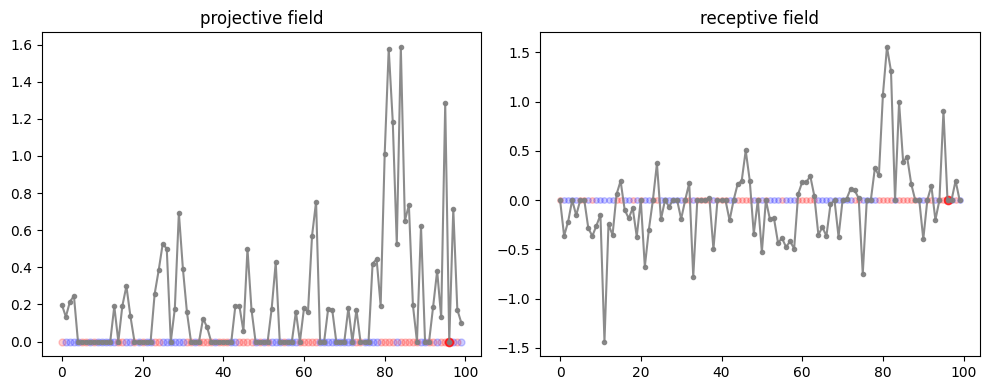

In [348]:
if embed_model:
    ind = random.randint(0,len(indE))
    # k = indE[ind]
    k = indE[ind]
    # k = ind
    print("neuron:", k)
    print("sign:", signJ[k])
    color = "red" if signJ[k] > 0 else "blue"

    plt.figure(figsize=(10,4))

    plt.subplot(121)
    plt.title('projective field')
    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=5, c='red', alpha=0.2)
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=5, c='blue', alpha=0.2)
        plt.plot(pos[k], 0, 'o', c=color, alpha=0.7);
        plt.plot(J[:,k], '.-', alpha=0.9, c='gray')
    else:
        plt.plot(pos[k,1], pos[k,0], 'o', c=color);
        plt.imshow(np.abs(J[:,k]).reshape(lN,lN))

    plt.subplot(122)
    plt.title('receptive field')
    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=4, c='red', alpha=0.2)
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=4, c='blue', alpha=0.2)
        plt.plot(pos[k], 0, 'o', c=color, alpha=0.7);
        plt.plot(J[k], '.-', alpha=0.9, c='gray');
    else:
        plt.plot(pos[k,1], pos[k,0], 'o', c=color);
        plt.imshow(J[k].reshape(lN,lN));

    plt.tight_layout();

In [350]:
k

96

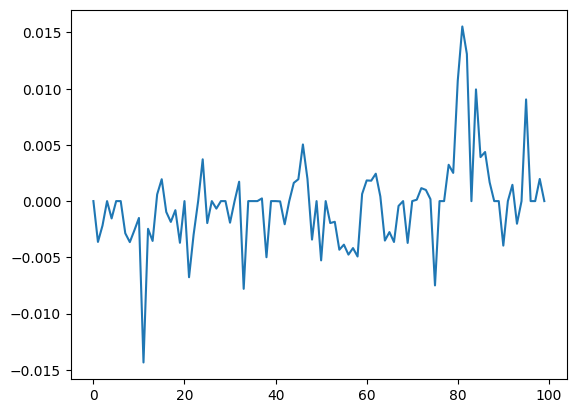

In [359]:
# dist[k]
# J[:,k]
# plt.plot(dist[k],J[:,k])


i=0
Jdist = np.zeros([N,N])

for E in indE:
    for k in range(N):
        Jdist[E,k]=J[E,k]/N
plt.plot(Jdist[96,:])

# for j in range(1,N):
#     for k in range(1,N):
#         if (dist[j,k]>=i and dist[j,k]<j):
#             print(dist[j,k])
#     i=j

In [325]:
dist[k]

array([94., 93., 92., 91., 90., 89., 88., 87., 86., 85., 84., 83., 82.,
       81., 80., 79., 78., 77., 76., 75., 74., 73., 72., 71., 70., 69.,
       68., 67., 66., 65., 64., 63., 62., 61., 60., 59., 58., 57., 56.,
       55., 54., 53., 52., 51., 50., 49., 48., 47., 46., 45., 44., 43.,
       42., 41., 40., 39., 38., 37., 36., 35., 34., 33., 32., 31., 30.,
       29., 28., 27., 26., 25., 24., 23., 22., 21., 20., 19., 18., 17.,
       16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,
        3.,  2.,  1.,  0.,  1.,  2.,  3.,  4.,  5.], dtype=float32)

### Look at E and I populations separately

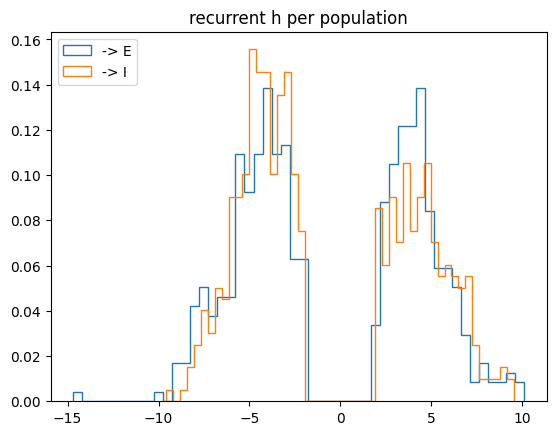

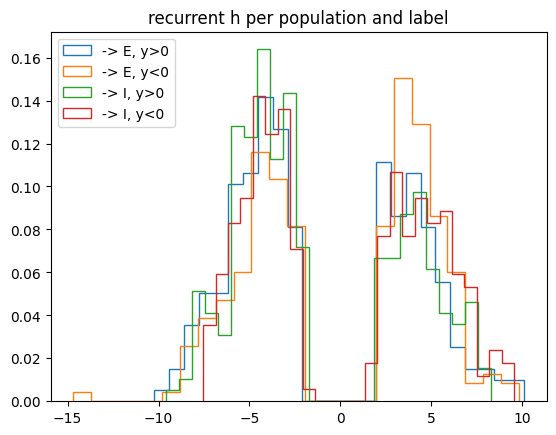

In [275]:
# fields per population
HfromE = X[:,indE] @ J[:,indE].T
HfromI = X[:,indI] @ J[:,indI].T

plt.hist(Hs[:,indE].flatten(), bins=50, density=True, histtype="step", label='-> E');
plt.hist(Hs[:,indI].flatten(), bins=50, density=True, histtype="step", label='-> I');
plt.title('recurrent h per population')
plt.legend();
plt.show();

plt.hist(Hs[:,indE][Y[:,indE]>0].flatten(), bins=25, density=True, histtype="step", label='-> E, y>0');
plt.hist(Hs[:,indE][Y[:,indE]<0].flatten(), bins=25, density=True, histtype="step", label='-> E, y<0');
plt.hist(Hs[:,indI][Y[:,indI]>0].flatten(), bins=25, density=True, histtype="step", label='-> I, y>0');
plt.hist(Hs[:,indI][Y[:,indI]<0].flatten(), bins=25, density=True, histtype="step", label='-> I, y<0');
plt.title('recurrent h per population and label')
plt.legend();
plt.show();

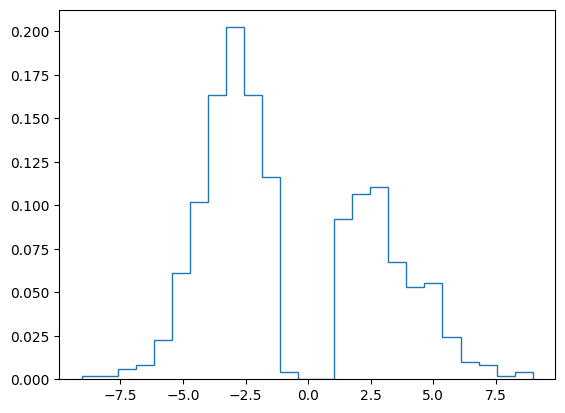

In [89]:
plt.hist(Hs[:,indI][Y[:,indI]<0].flatten(), bins=25, density=True, histtype="step", label='-> I, y<0');

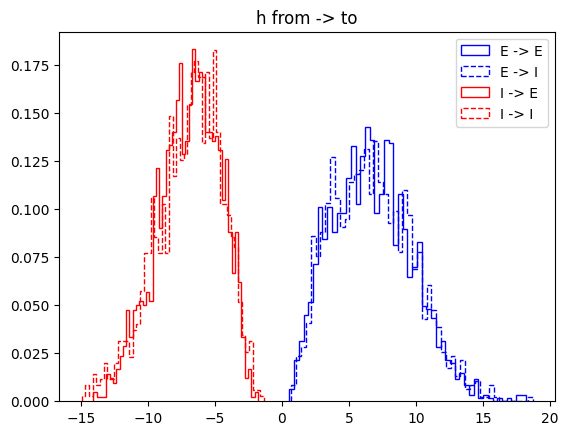

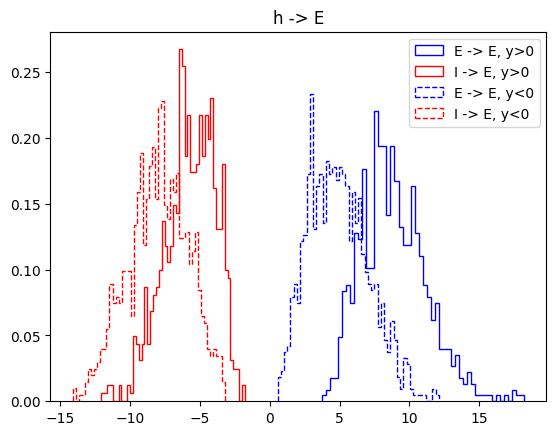

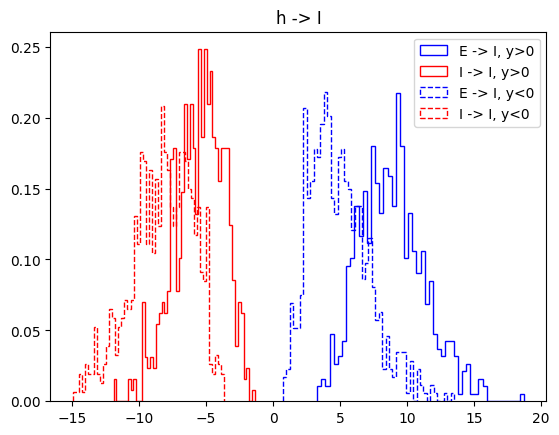

In [90]:
# fields per channel
plt.hist(HfromE[:,indE].flatten(), bins=50, density=True, histtype="step", label='E -> E', color='blue');
plt.hist(HfromE[:,indI].flatten(), bins=50, density=True, histtype="step", label='E -> I', color='blue', ls='--');
plt.hist(HfromI[:,indE].flatten(), bins=50, density=True, histtype="step", label='I -> E', color='red');
plt.hist(HfromI[:,indI].flatten(), bins=50, density=True, histtype="step", label='I -> I', color='red', ls='--');
plt.title('h from -> to')
plt.legend();
plt.show()

## fields to E per label
plt.hist(HfromE[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> E, y>0');
plt.hist(HfromI[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> E, y>0');
plt.hist(HfromE[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> E, y<0');
plt.hist(HfromI[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> E, y<0');
plt.title('h -> E')
plt.legend();
plt.show()

## fields to I per label
plt.hist(HfromE[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> I, y>0');
plt.hist(HfromI[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> I, y>0');
plt.hist(HfromE[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> I, y<0');
plt.hist(HfromI[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> I, y<0');
plt.title('h -> I')
plt.legend();
plt.show()

## Results

### Input covariance vs. Interquartile range

In [426]:
def get_IQR(H):
    Q3, Q1 = np.percentile(H, [75,25])
    IQR = Q3 - Q1
    return IQR

def get_IPR(H):
    P3, P1 = np.percentile(H, [99,1])
    IPR = P3 - P1
    return IPR
    
def get_FWHM(x):
    """ returns coarse full width at half maximum, and the two
        xcoordinates of the first and last values above the half maximum """
    where, = np.where(x >= x.max()*0.5)
    print(where)
    maxi = where[-1]
    mini = where[0]
    return maxi-mini#, mini, maxi

xi=1e-06
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


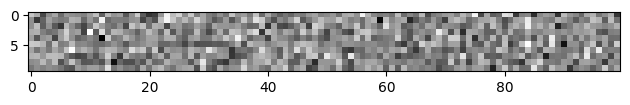

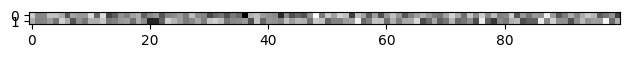

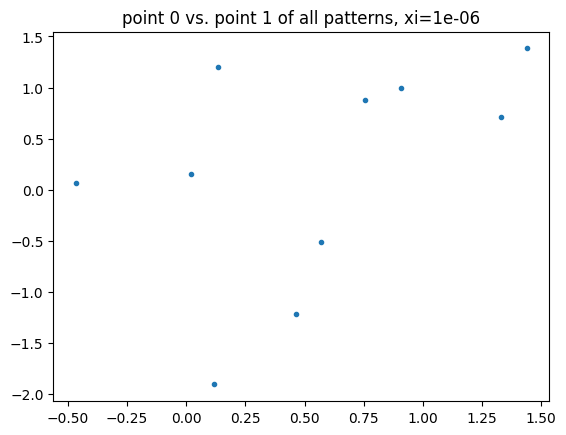

ep: 0 loss: 0.39 sign reg: 0.020890677124995746
ep: 50 loss: 0.0 sign reg: 6.018697243254232e-22
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

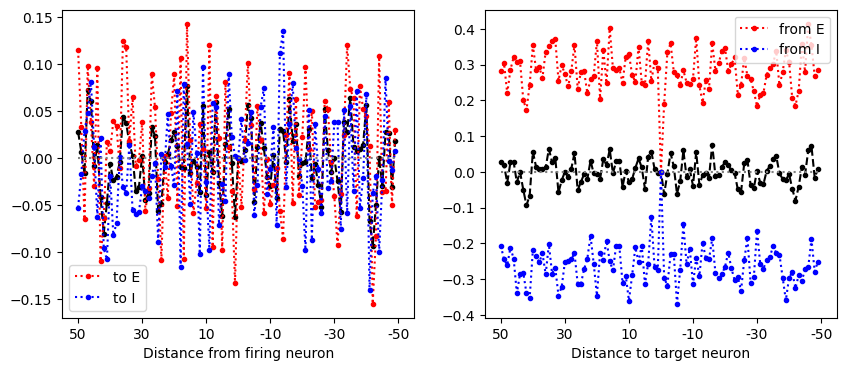

[ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 52
 53 54 55 56 57 58 59 60 61 62 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 81 82 83 84 85 86 87 88 89 90 93 94 95 96 97 98 99]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 49
 51 52 53 54 55 56 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 78 79 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
[ 0  3  6 14 15 23 30 32 34 41 46 53 66 71 84 85 88 94]
[ 4 31 33 39 47 58 63 64 67 87 90 96]
xi=0.400001
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


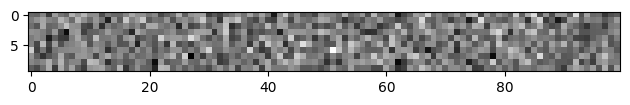

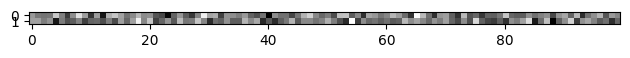

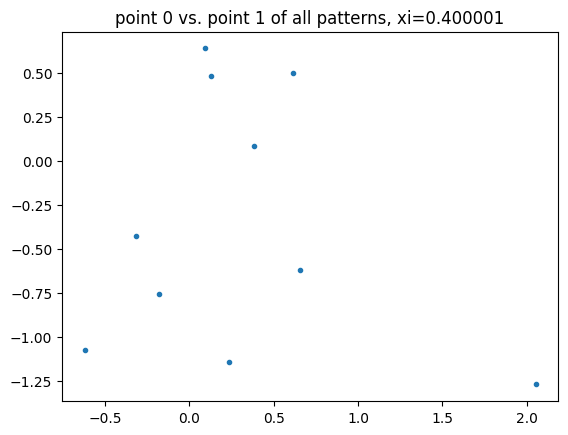

ep: 0 loss: 0.399 sign reg: 0.01894842928558224
ep: 50 loss: 0.0 sign reg: 7.144035918382558e-11
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

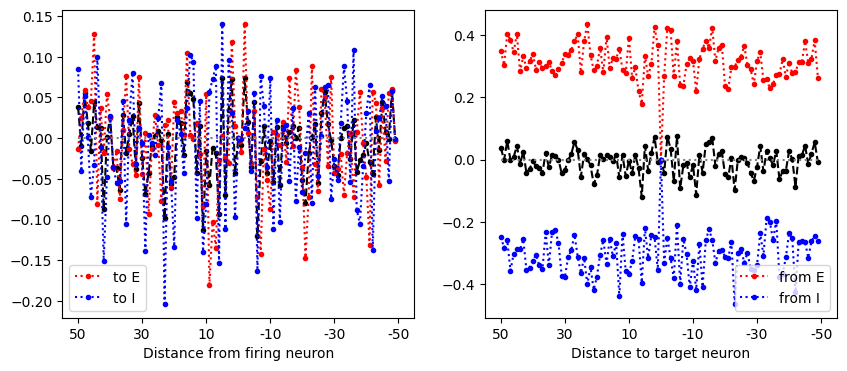

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48
 49 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 49
 51 52 53 54 56 57 58 59 60 61 62 63 64 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 85 87 88 89 90 91 92 93 94 95 96 97 98 99]
[ 5 15 19 34 48 52 66 68 73 79]
[ 0  6 17 35 36 42 43 45 47 57 60 83 86]
xi=0.8000010000000001
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


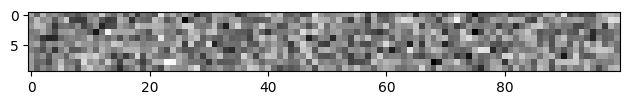

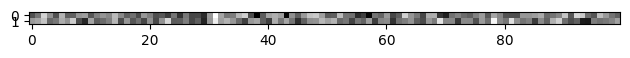

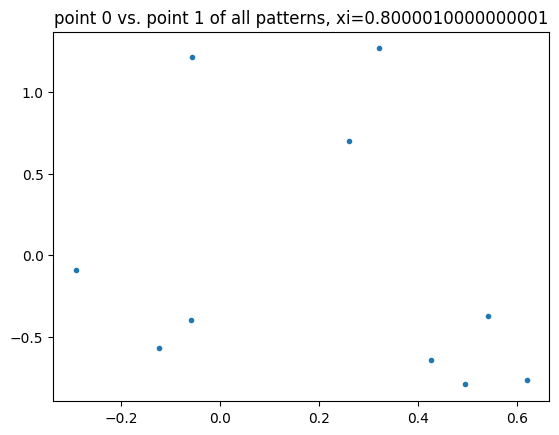

ep: 0 loss: 0.402 sign reg: 0.02049712103346988
ep: 50 loss: 0.0 sign reg: 5.0252604505748597e-29
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

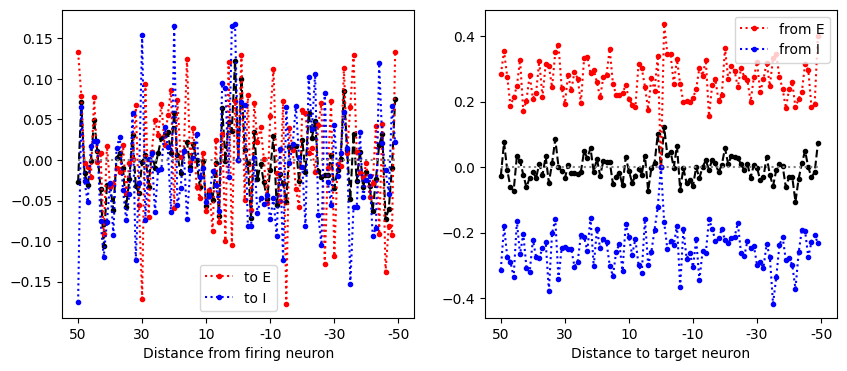

[ 0  1  2  5  6  9 11 12 14 15 16 17 18 19 21 22 23 24 26 27 28 29 30 32
 33 34 35 36 38 39 43 44 45 47 48 49 51 52 53 54 55 56 61 62 63 64 66 67
 69 70 71 72 73 74 75 76 77 79 80 81 82 83 84 85 86 87 88 90 91 94 95 96
 99]
[ 0  2  3  4  6  8  9 10 11 12 13 14 15 18 19 20 21 22 23 24 26 27 29 31
 32 33 34 35 36 37 38 40 41 42 43 44 46 47 52 53 54 56 58 59 60 61 62 63
 64 67 68 70 71 72 73 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 96 97 99]
[ 0  1  5 18 21 26 29 31 34 47 49 51 53 55 61 64 76 79 83 86 99]
[20 30 45 46 48 49 72 74 94]
xi=1.200001
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


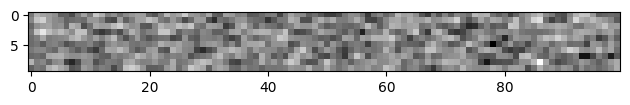

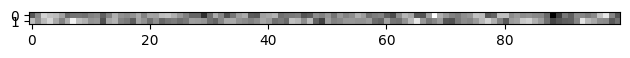

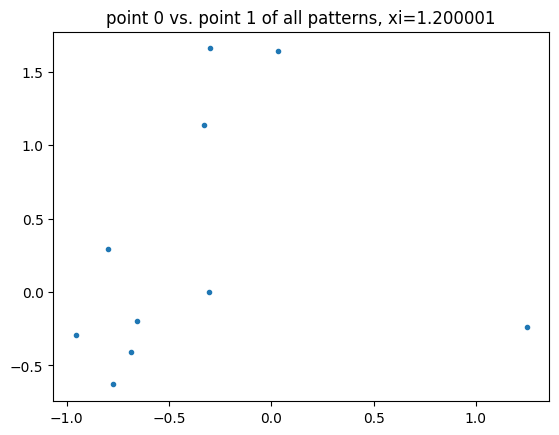

ep: 0 loss: 0.41 sign reg: 0.019819039586012246
ep: 50 loss: 0.0 sign reg: 4.3605965827401127e-10
ep: 100 loss: 0.0 sign reg: 1.0214711525072674e-13
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

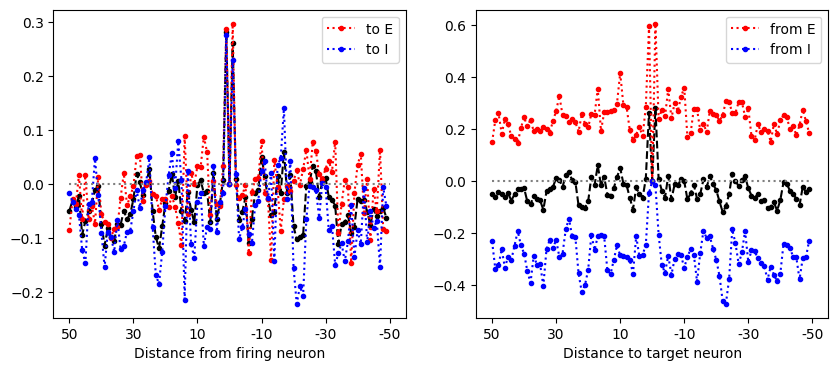

[21 33 40 49 51 55 59 60 73 74 77 78]
[ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 21 22 27 28 29 30 32
 36 37 38 39 40 41 42 43 44 46 47 48 53 54 55 56 57 58 59 60 61 62 63 64
 65 69 70 71 72 73 74 76 77 78 80 81 82 83 84 85 86 87 88 89 90 91 92 93
 94 95 96 97 98]
[49 51]
[49 51 67]
xi=1.600001
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


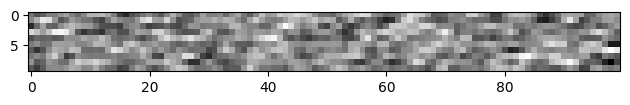

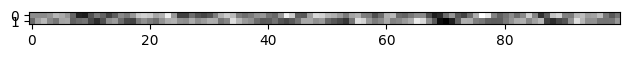

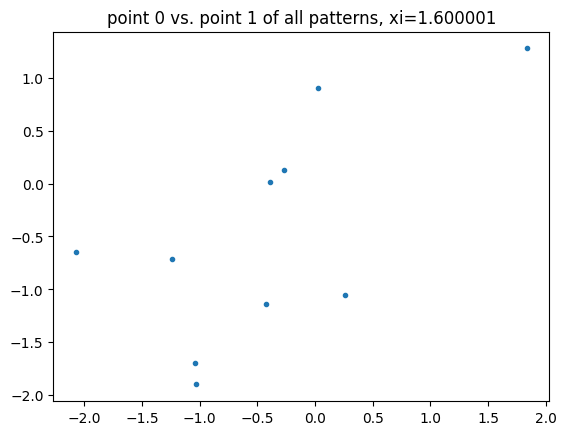

ep: 0 loss: 0.391 sign reg: 0.018704470079086065
ep: 50 loss: 0.0 sign reg: 1.8447209973180894e-12
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

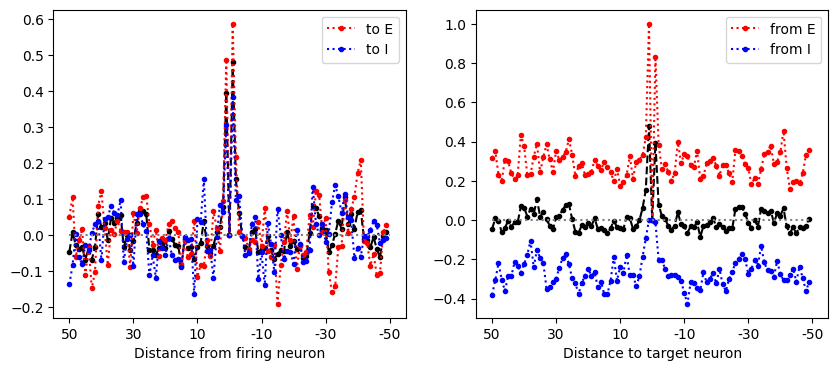

[49 51]
[ 0  1  2  3  4  5  6  7  8  9 10 13 16 17 18 19 20 21 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 39 40 41 43 44 45 46 54 55 56 57 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 80 81 83 85 86 87 88 90 91 92
 93 94 95 96 97 98 99]
[49 51]
[49 51]
xi=2.000001
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


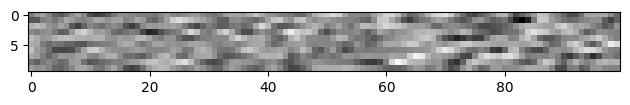

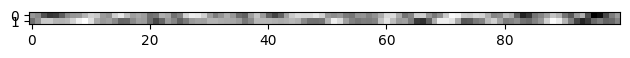

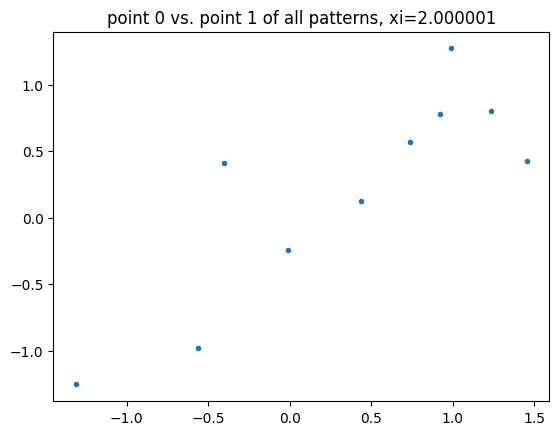

ep: 0 loss: 0.407 sign reg: 0.02041843159129217
ep: 50 loss: 0.0 sign reg: 2.4978504195343457e-12
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

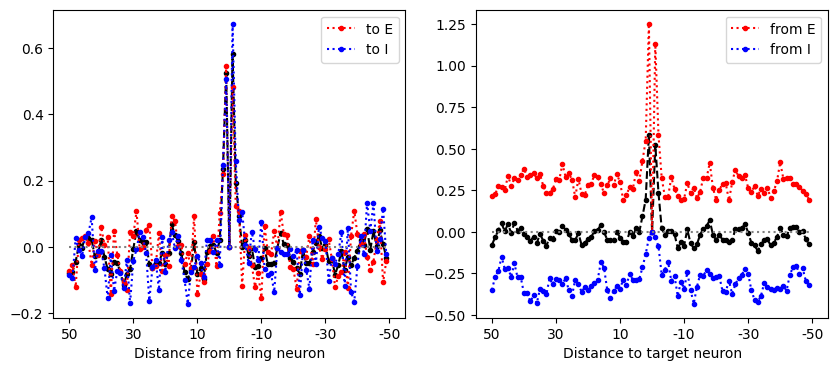

[49 51]
[ 0  1  2  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 53 54 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 96 97 98 99]
[49 51]
[49 51]
xi=2.4000010000000005
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


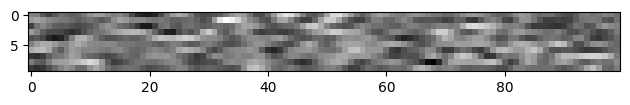

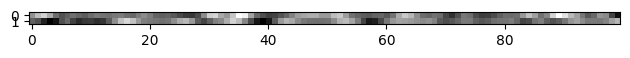

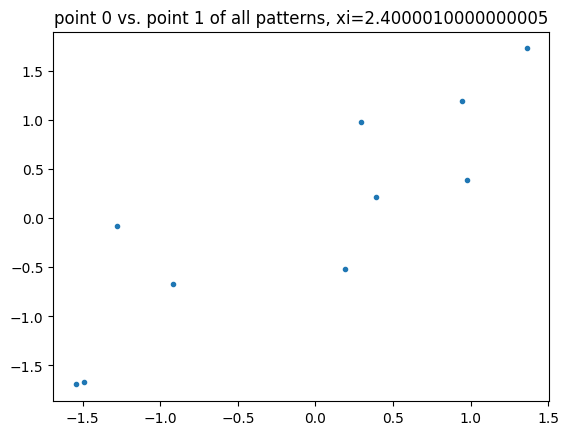

ep: 0 loss: 0.376 sign reg: 0.016805357311329584
ep: 50 loss: 0.0 sign reg: 5.319261250269585e-13
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

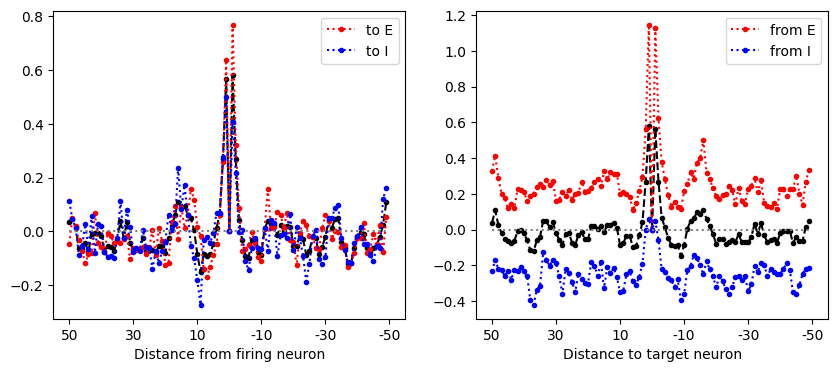

[49 51 52]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 21 22 23 24 25 26 27 28 29
 30 33 35 36 37 38 39 40 41 42 43 44 45 46 53 54 55 56 57 58 59 60 61 66
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 83 86 87 88 89 90 91 93 94 95
 96 97 98 99]
[49 51]
[48 49 51]
xi=2.8000010000000004
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


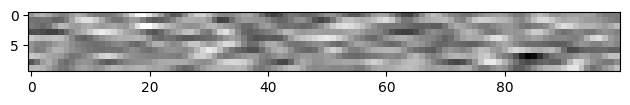

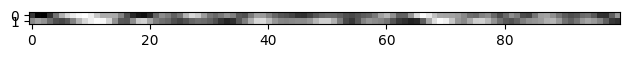

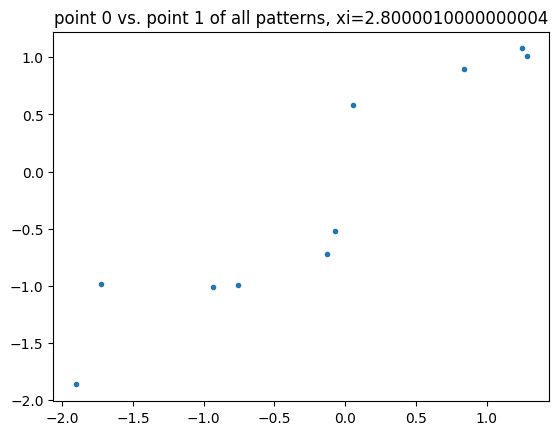

ep: 0 loss: 0.345 sign reg: 0.0197962813410176
ep: 50 loss: 0.0 sign reg: 2.267121179865553e-09
ep: 100 loss: 0.0 sign reg: 6.545535484894014e-16
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

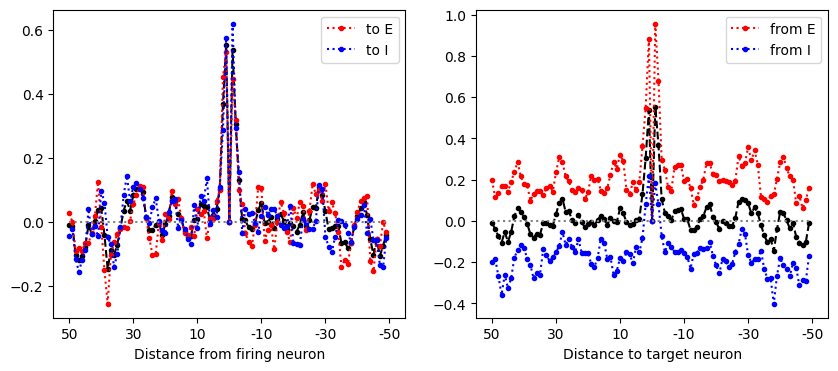

[48 49 51 52]
[ 2  3  4  5  6 12 13 14 15 31 32 38 39 44 62 70 71 74 75 81 85 86 87 88
 89 91 92 93 94 95 96 97 98]
[48 49 51 52]
[49 51]
xi=3.2000010000000003
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


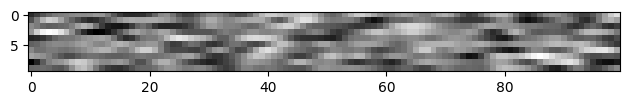

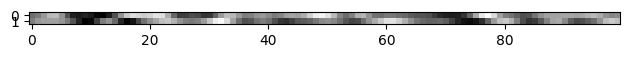

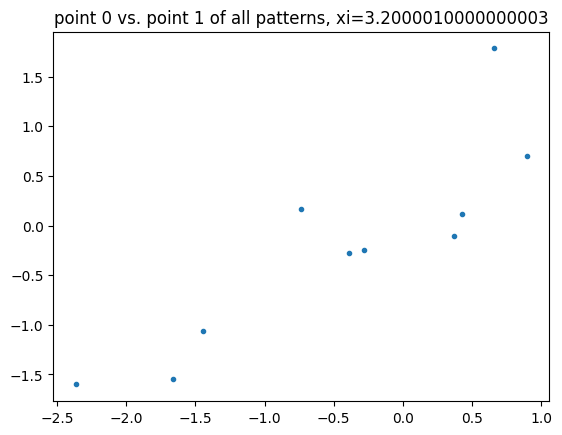

ep: 0 loss: 0.362 sign reg: 0.017783027514303724
ep: 50 loss: 0.0 sign reg: 1.1697956394788457e-13
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

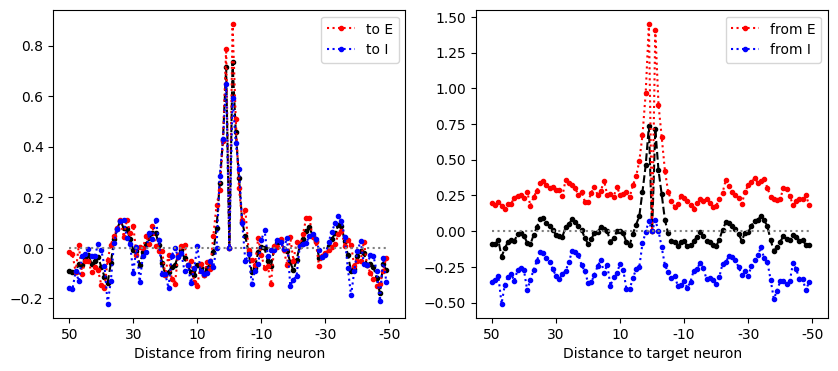

[48 49 51 52]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 19 20 21 22 23 29 30 31 32 35
 37 38 39 41 42 43 44 45 55 56 57 58 59 60 61 62 63 64 66 67 68 69 70 71
 78 79 80 87 88 89 90 91 92 93 95 96 97 98 99]
[49 51 52]
[48 49 51 52]
xi=3.6000010000000002
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


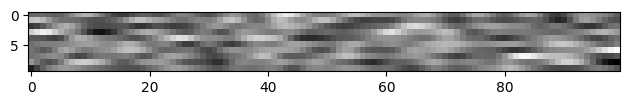

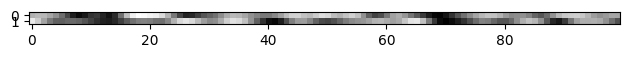

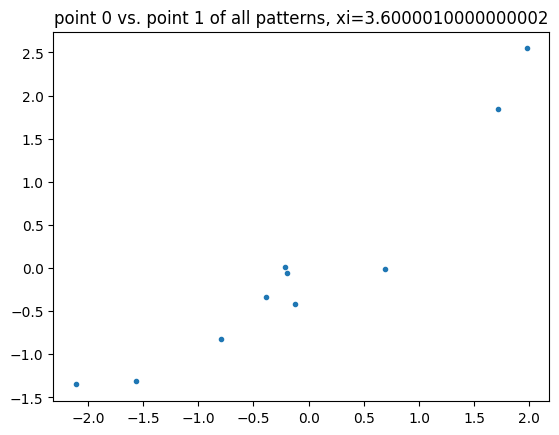

ep: 0 loss: 0.355 sign reg: 0.01575763785541034
ep: 50 loss: 0.009 sign reg: 5.033936932596001e-05
ep: 100 loss: 0.001 sign reg: 6.57056147326221e-07
ep: 150 loss: 0.0 sign reg: 2.93185160033157e-19
zero loss converged at 150 epochs


<Figure size 640x480 with 0 Axes>

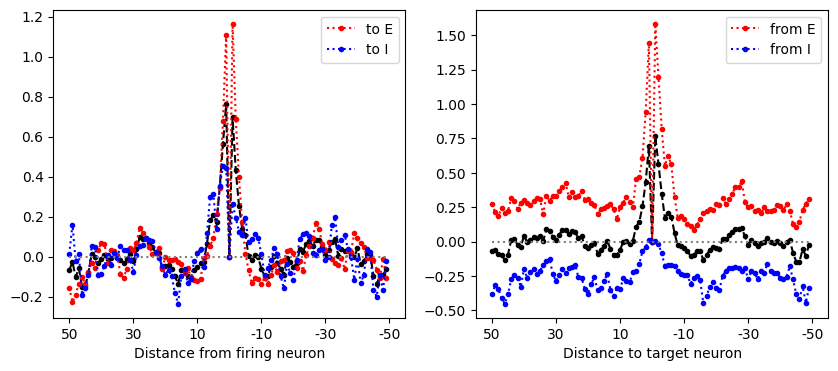

[48 49 51 52 53]
[ 0  1  2  3  4  5  6  7  8  9 11 14 19 20 21 23 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 59 60 61 62 63 64 65 66 67 68 69 70 71 72 80
 82 83 85 88 89 90 91 92 94 95 96 97 98 99]
[48 49 51 52]
[44 45 47 48 49 51]
xi=4.000001
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


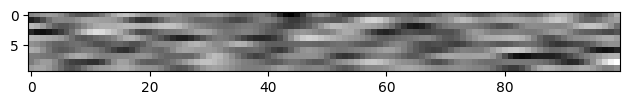

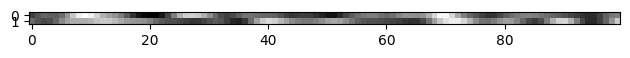

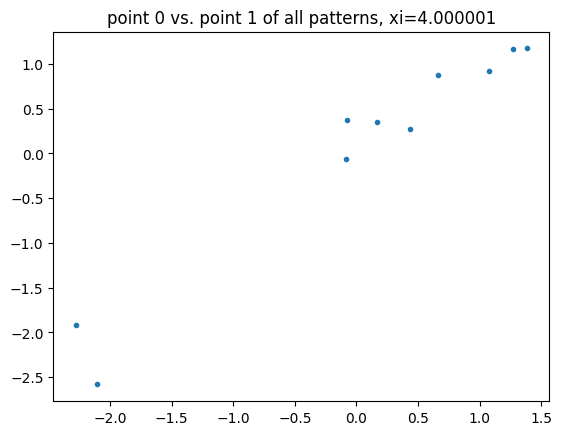

ep: 0 loss: 0.383 sign reg: 0.018363646518614142
ep: 50 loss: 0.0 sign reg: 8.505187970973477e-09
ep: 100 loss: 0.0 sign reg: 1.0871293255301146e-15
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

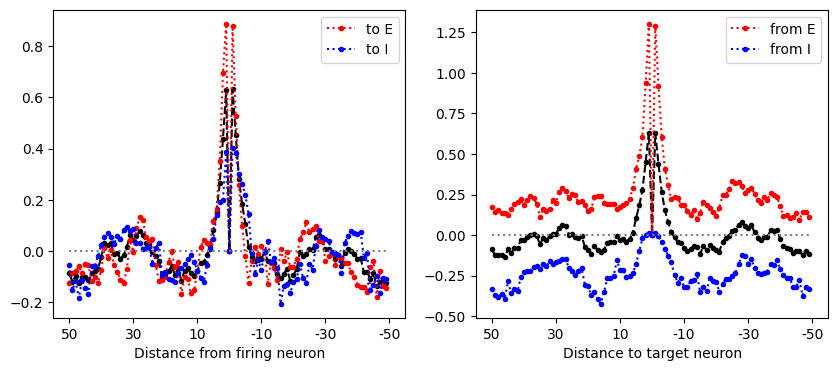

[48 49 51 52]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 15 25 26 27 29 30 31 32 33 34 35
 36 37 38 40 41 42 43 44 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 83 84 85 86 91 92 93 94 95 96 97 98 99]
[48 49 51 52]
[49 51 52 53 54 55]
xi=4.4000010000000005
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


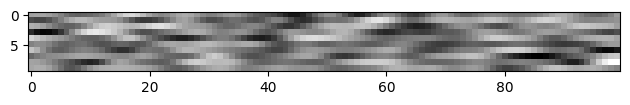

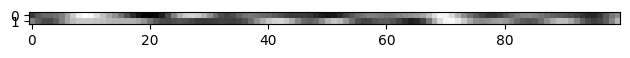

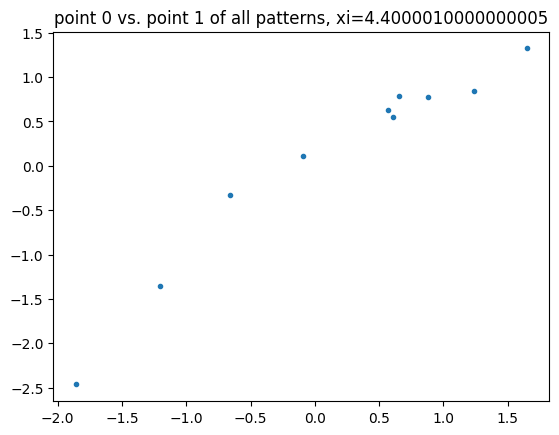

ep: 0 loss: 0.365 sign reg: 0.01802182883002078
ep: 50 loss: 0.0 sign reg: 6.958098020387763e-18
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

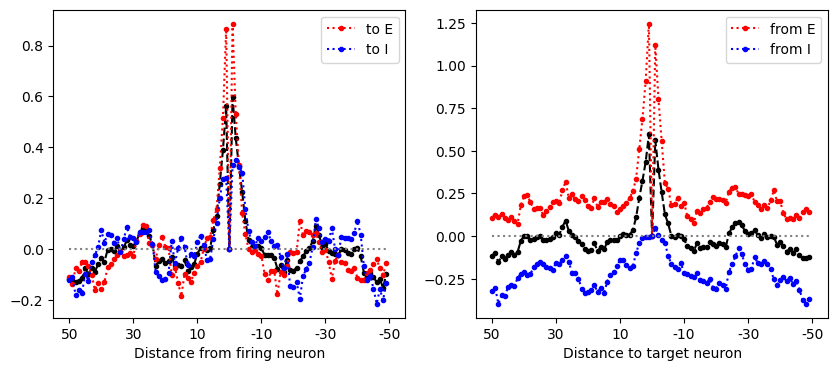

[47 48 49 51 52]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 88 89 90 91 92 93
 94 95 96 97 98 99]
[48 49 51 52]
[47 48 49 51 52 53 54]
xi=4.800001000000001
1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 2, num label: 1


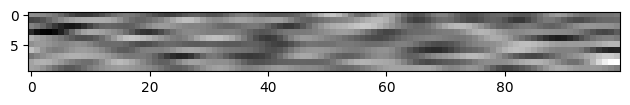

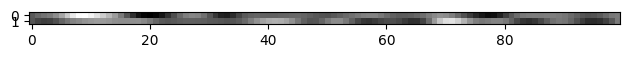

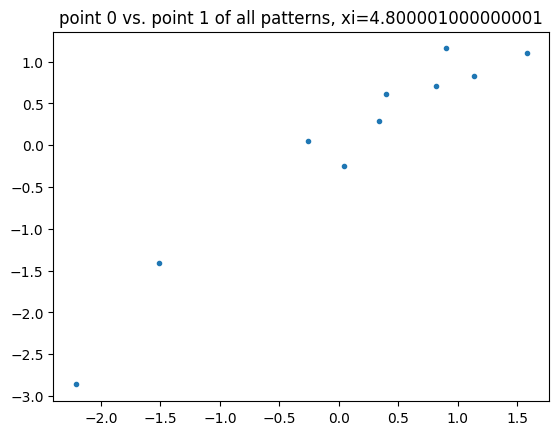

ep: 0 loss: 0.391 sign reg: 0.016648138942607665
ep: 50 loss: 0.0 sign reg: 1.5286099817539709e-15
zero loss converged at 50 epochs


<Figure size 640x480 with 0 Axes>

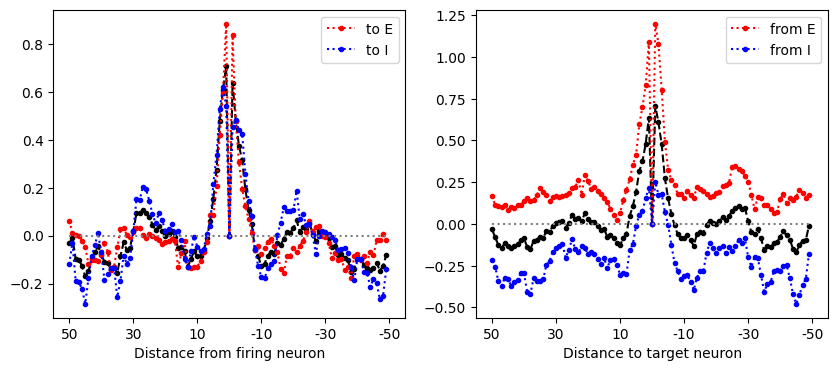

[47 48 49 51 52 53]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 36 39 40 41 42 58 59
 60 61 62 63 64 65 66 81 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]
[48 49 51 52]
[46 47 48 49 51 52 53 54]


<Figure size 640x480 with 0 Axes>

In [428]:
##### Verbose option
print_every = 50

# Initialize holders
IQRsEE, IQRsEI, IQRsIE, IQRsII = ([] for i in range(4))
IPRsEE, IPRsEI, IPRsIE, IPRsII = ([] for i in range(4))
IQRsEEPositive, IQRsEIPositive, IQRsIEPositive, IQRsIIPositive = ([] for i in range(4))
IQRsEENegative, IQRsEINegative, IQRsIENegative, IQRsIINegative = ([] for i in range(4))
JmeanfromE_FWHM, JmeanfromI_FWHM, JmeantoE_FWHM, JmeantoI_FWHM = ([] for i in range(4))
JmeanfromE_peaks, JmeanfromI_peaks, JmeantoE_peaks, JmeantoI_peaks = ([] for i in range(4))

train_errs = []
train_enregs = []
train_signregs = []
train_posregs = []

# Correlation values to be tested
xis_range = np.arange(1e-6,5,0.4)#(1e-4,3,0.9)

for xi in xis_range:
    print(f'xi={xi}')
    pars.xis = [xi] # Redefine lenght-scales of mixtures
    
    # Get a dataset
    train_dataset, test_dataset, teacher_weights, x_teacher, X, Y = get_new_dataset(pars) # Generate a new dataset
    
    # Visualize the data
    # Show data
    watch_dataset(train_dataset, test_dataset, pars)                                # Show the data
    # Show correlation between data
    X_to_plot_train, y_to_plot_train = extract_tensors(train_dataset)
    # First data-point vs 2nd data-point, to see correlation between them (only training dataset)
    plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,1], '.');
    #plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,2], '.');
    plt.title(f"point 0 vs. point 1 of all patterns, xi={xi}")
    plt.savefig(f'{pars.save_dir}/Correlation-xi{xi}.png')
    plt.show()
    plt.clf()
    
    # Train the network
    J, I, errs, en_regs, sign_regs, pos_regs  = train_network(X, Y, N, P, J0, I0)   # Train a new network
    train_errs.append(errs[-1])
    #train_enregs.append(en_regs[-1])
    train_signregs.append(sign_regs[-1])
    #train_posregs.append(pos_regs[-1])
    
    # Find index for E and I neurons
    signJ = (2. * (J > 0.) - 1.).mean(0)  # Mean sign of the output of each variable (should be ideally 1 or -1, or 0 if the neuron is inactive)
    if fe > 0:                              # If the sign is predefined, we already know which are positive and negative
        indE = range(Ne)   
        indI = range(Ne,N)
    else:                                   # If the sign is not predefined, choose those which are positive and negative
        indE = np.arange(N)[signJ > 1e-6]
        indI = np.arange(N)[signJ <= 1e-6]
    
    # # Get fields per population
    # HfromE = X[:,indE] @ J[:,indE].T    # 
    # HfromI = X[:,indI] @ J[:,indI].T
    
    # # Plot h for different populations

    # # fields per channel
    # plt.hist(HfromE[:,indE].flatten(), bins=50, density=True, histtype="step", label='E -> E', color='blue');
    # plt.hist(HfromE[:,indI].flatten(), bins=50, density=True, histtype="step", label='E -> I', color='blue', ls='--');
    # plt.hist(HfromI[:,indE].flatten(), bins=50, density=True, histtype="step", label='I -> E', color='red');
    # plt.hist(HfromI[:,indI].flatten(), bins=50, density=True, histtype="step", label='I -> I', color='red', ls='--');
    # plt.title(f'h from -> to, xi={xi}')
    # plt.legend();
    # plt.savefig(f'{pars.save_dir}/xi{xi}-h-fromTo.png')
    # plt.show()
    # plt.clf() 
    # IQRsEE.append(get_IQR(HfromE[:,indE].flatten()))
    # IQRsIE.append(get_IQR(HfromE[:,indI].flatten()))
    # IQRsEI.append(get_IQR(HfromI[:,indE].flatten()))
    # IQRsII.append(get_IQR(HfromI[:,indI].flatten()))

    # IPRsEE.append(get_IPR(HfromE[:,indE].flatten()))
    # IPRsIE.append(get_IPR(HfromE[:,indI].flatten()))
    # IPRsEI.append(get_IPR(HfromI[:,indE].flatten()))
    # IPRsII.append(get_IPR(HfromI[:,indI].flatten()))
    
    # ## fields to E per label
    # plt.hist(HfromE[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> E, y>0');
    # plt.hist(HfromI[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> E, y>0');
    # plt.hist(HfromE[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> E, y<0');
    # plt.hist(HfromI[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> E, y<0');
    # plt.title(f'h -> E, xi={xi} ')
    # plt.legend();
    # plt.savefig(f'{pars.save_dir}/xi{xi}-h-toE.png')
    # plt.show()
    # plt.clf() 
    
    # plt.hist(HfromE[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> I, y>0');
    # plt.hist(HfromI[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> I, y>0');
    # plt.hist(HfromE[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> I, y<0');
    # plt.hist(HfromI[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> I, y<0');
    # plt.title(f'h -> I, xi={xi}')
    # plt.legend();
    # plt.savefig(f'{pars.save_dir}/xi{xi}-h-toI.png')
    # plt.show()
    # plt.clf() 

    # IQRsEEPositive.append(get_IQR(HfromE[:,indE][Y[:,indE]>0]))
    # IQRsIEPositive.append(get_IQR(HfromE[:,indI][Y[:,indI]>0]))
    # IQRsEIPositive.append(get_IQR(HfromI[:,indE][Y[:,indE]>0]))
    # IQRsIIPositive.append(get_IQR(HfromI[:,indI][Y[:,indI]>0]))

    # IQRsEENegative.append(get_IQR(HfromE[:,indE][Y[:,indE]<0]))
    # IQRsIENegative.append(get_IQR(HfromE[:,indI][Y[:,indI]<0]))
    # IQRsEINegative.append(get_IQR(HfromI[:,indE][Y[:,indE]<0]))
    # IQRsIINegative.append(get_IQR(HfromI[:,indI][Y[:,indI]<0]))


    # Initialize holders
    Jmeanto = np.zeros(N)
    Jmeanfrom = np.zeros(N)
    JmeantoE = np.zeros(N)
    JmeantoI = np.zeros(N)
    JmeanfromE = np.zeros(N)
    JmeanfromI = np.zeros(N)
    
    # On average, what's the J from/to an E/I neuron
    for k in range(N):
        Jmeanto += np.roll(J[k], -k+N//2) * 1/N      
        Jmeanfrom += np.roll(J[:,k], -k+N//2) * 1/N
        if k in indE:
            JmeantoE += np.roll(J[k], -k+N//2) / Ne_eff
            JmeanfromE += np.roll(J[:,k], -k+N//2) / Ne_eff
        if k in indI:
            JmeantoI += np.roll(J[k], -k+N//2) / Ni_eff
            JmeanfromI += np.roll(J[:,k], -k+N//2) / Ni_eff
        
    plt.figure(figsize=(10,4))
    
    if dim == 1:
        plt.subplot(121)
        plt.plot(Jmeanto, '.--', c='k', );
        plt.plot(JmeantoE, '.:', c='red', label='to E');
        plt.plot(JmeantoI, '.:', c='blue', label='to I');
        plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');
        plt.xticks([i for i in range(0,N+1,N//5)],np.arange(N // 2, -(N // 2 )-20, -N//5).tolist())
        plt.xlabel('Distance from firing neuron')
        plt.legend();
    
        plt.subplot(122)
        plt.plot(Jmeanfrom, '.--', c='k');
        plt.plot(JmeanfromE, '.:', c='red', label='from E');
        plt.plot(JmeanfromI, '.:', c='blue', label='from I');
        plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');
        plt.xticks([i for i in range(0,N+1,N//5)],np.arange(N // 2, -(N // 2 )-20, -N//5).tolist())
        plt.xlabel('Distance to target neuron')
        plt.legend();
    else:
        plt.subplot(231)
        plt.imshow(Jmeanto.reshape(lN,lN))
        plt.subplot(232)
        plt.imshow(JmeantoE.reshape(lN,lN))
        plt.subplot(233)
        plt.imshow(JmeantoI.reshape(lN,lN))
        
        plt.subplot(234)
        plt.imshow(Jmeanfrom.reshape(lN,lN))
        plt.subplot(235)
        plt.imshow(JmeanfromE.reshape(lN,lN))
        plt.subplot(236)
        plt.imshow(-JmeanfromI.reshape(lN,lN))
    plt.savefig(f'{pars.save_dir}/xi{xi}-Js.png')
    plt.show()
    plt.clf() 

    JmeanfromE_FWHM.append(get_FWHM(JmeanfromE))
    JmeanfromI_FWHM.append(get_FWHM(-JmeanfromI))
    JmeantoE_FWHM.append(get_FWHM(JmeantoE))
    JmeantoI_FWHM.append(get_FWHM(JmeantoI))
    JmeanfromE_peaks.append(max(JmeanfromE))
    JmeanfromI_peaks.append(min(JmeanfromI))
    JmeantoE_peaks.append(max(JmeantoE))
    JmeantoI_peaks.append(max(JmeantoI))

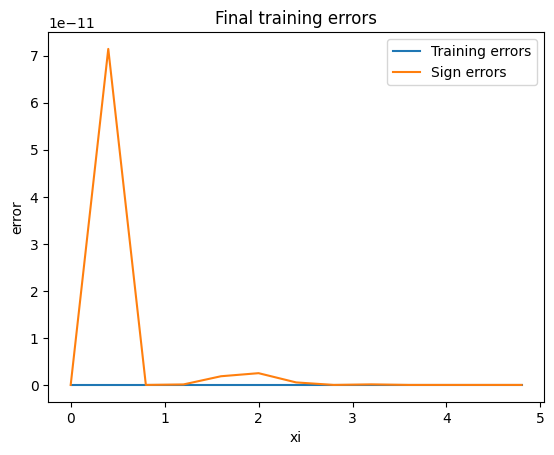

In [429]:
plt.plot(xis_range, train_errs, label='Training errors')
plt.plot(xis_range, train_signregs, label='Sign errors')
plt.title('Final training errors')
plt.xlabel('xi')
plt.ylabel('error')
plt.legend()
plt.savefig(f'{pars.save_dir}/errors.png')
plt.show()

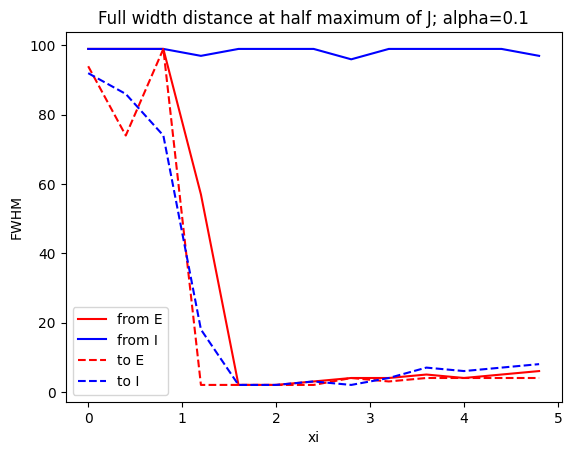

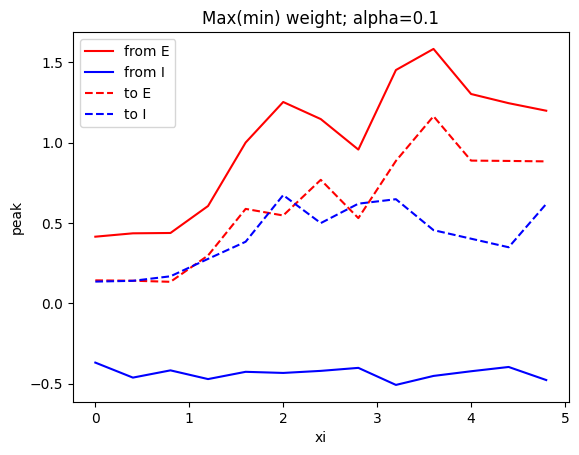

In [430]:
plt.plot(xis_range, JmeanfromE_FWHM, color='red', label='from E')
plt.plot(xis_range, JmeanfromI_FWHM, color='blue', label='from I')
plt.plot(xis_range, JmeantoE_FWHM, color='red', ls='--', label='to E')
plt.plot(xis_range, JmeantoI_FWHM, color='blue', ls='--', label='to I')
plt.title(f'Full width distance at half maximum of J; alpha={pars.alpha_train}')
plt.xlabel('xi')
plt.ylabel('FWHM')
plt.legend()
plt.savefig(f'{pars.save_dir}/J_FWHM.png')
plt.show()

plt.plot(xis_range, JmeanfromE_peaks, color='red', label='from E')
plt.plot(xis_range, JmeanfromI_peaks, color='blue', label='from I')
plt.plot(xis_range, JmeantoE_peaks, color='red', ls='--', label='to E')
plt.plot(xis_range, JmeantoI_peaks, color='blue', ls='--', label='to I')
plt.title(f'Max(min) weight; alpha={pars.alpha_train}')
plt.xlabel('xi')
plt.ylabel('peak')
plt.legend()
plt.savefig(f'{pars.save_dir}/J_peaks.png')
plt.show()

In [425]:
0.5*0.25

0.125

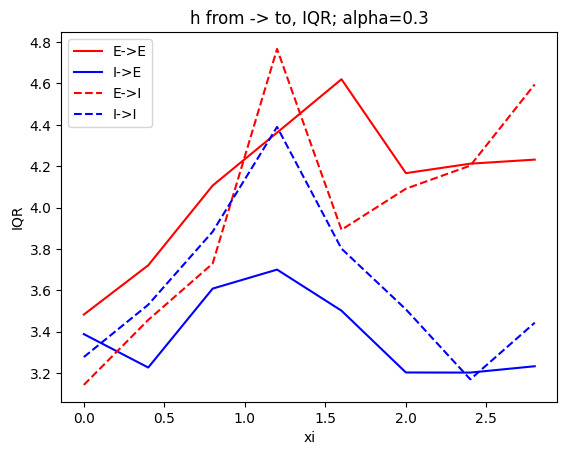

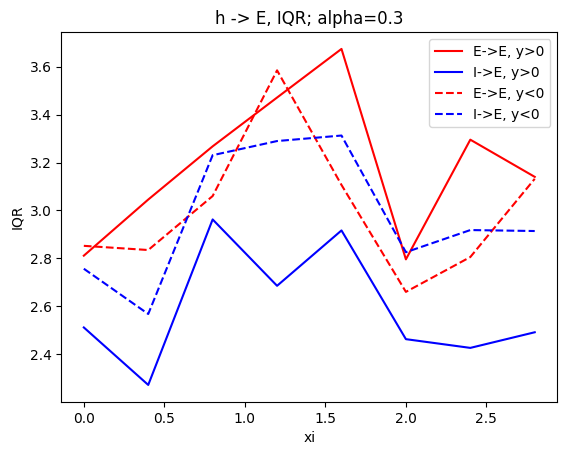

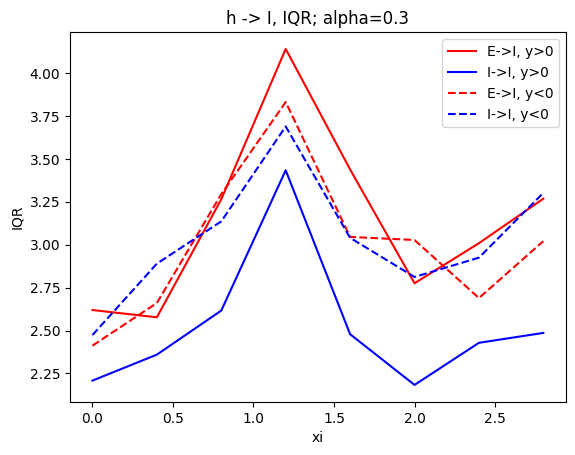

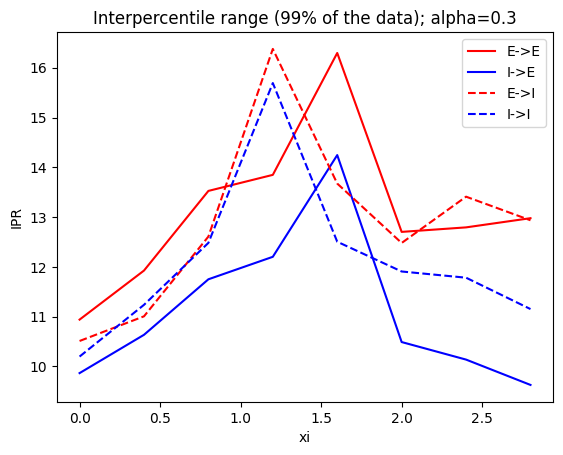

In [180]:
plt.plot(xis_range,IQRsEE, color='red', label='E->E')
plt.plot(xis_range,IQRsEI, color='blue', label='I->E')
plt.plot(xis_range,IQRsIE, color='red', ls='--', label='E->I')
plt.plot(xis_range,IQRsII, color='blue', ls='--', label='I->I')
plt.title(f'h from -> to, IQR; alpha={pars.alpha_train}')
plt.xlabel('xi')
plt.ylabel('IQR')
plt.legend()
plt.savefig(f'{pars.save_dir}/hFrom-To_IQR.png')
plt.show()

plt.plot(xis_range,IQRsEEPositive, color='red', label='E->E, y>0')
plt.plot(xis_range,IQRsEIPositive, color='blue', label='I->E, y>0')
plt.plot(xis_range,IQRsEENegative, color='red', ls='--', label='E->E, y<0')
plt.plot(xis_range,IQRsEINegative, color='blue', ls='--', label='I->E, y<0')
plt.title(f'h -> E, IQR; alpha={pars.alpha_train}')
plt.xlabel('xi')
plt.ylabel('IQR')
plt.legend()
plt.savefig(f'{pars.save_dir}/hTo-E_IQR.png')
plt.show()

plt.plot(xis_range,IQRsIEPositive, color='red', label='E->I, y>0')
plt.plot(xis_range,IQRsIIPositive, color='blue', label='I->I, y>0')
plt.plot(xis_range,IQRsIENegative, color='red', ls='--', label='E->I, y<0')
plt.plot(xis_range,IQRsIINegative, color='blue', ls='--', label='I->I, y<0')
plt.title(f'h -> I, IQR; alpha={pars.alpha_train}')
plt.xlabel('xi')
plt.ylabel('IQR')
plt.legend()
plt.savefig(f'{pars.save_dir}/hTo-I_IQR.png')
plt.show()

plt.plot(xis_range,IPRsEE, color='red', label='E->E')
plt.plot(xis_range,IPRsEI, color='blue', label='I->E')
plt.plot(xis_range,IPRsIE, color='red', ls='--', label='E->I')
plt.plot(xis_range,IPRsII, color='blue', ls='--', label='I->I')
plt.title(f'Interpercentile range (99% of the data); alpha={pars.alpha_train}')
plt.xlabel('xi')
plt.ylabel('IPR')
plt.legend()
plt.savefig(f'{pars.save_dir}/hFrom-To_IPR.png')
plt.show()